# **0. Csomagok telepítése, importálása**

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 27.8 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import linear_model
import xgboost as xgb

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

import shap

import itertools

In [ ]:
!pip install sqlalchemy psycopg2
!conda install -y sqlalchemy psycopg2

/bin/bash: conda: command not found


# **1. Adatbetöltés**

In [ ]:
from sqlalchemy import create_engine


POSTGRES_ADDRESS = 'o-o-o.hu' 
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'aragacs' 
POSTGRES_PASSWORD = 'HulaPOOP'
POSTGRES_DBNAME = 'ooo'

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME,password=POSTGRES_PASSWORD,ipaddress=POSTGRES_ADDRESS,port=POSTGRES_PORT,dbname=POSTGRES_DBNAME))

cnx = create_engine(postgres_str)

The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.


In [ ]:
gepkocsi_friss = pd.read_sql_query('''SELECT * FROM tstar.tvalue WHERE topicid='TAAR001' AND tyear=2018;''', cnx)

In [ ]:
gepkocsi_friss.head()

tyear  kshkod  topicid  tvalue  geonameid  datatypeid  publicornot  \
0   2018   10904  TAAR001     107    11088.0        2205         True   
1   2018   17419  TAAR001     149    16494.0        2205         True   
2   2018   24077  TAAR001    1372    16497.0        2205         True   
3   2018    3513  TAAR001     346    10964.0        2205         True   
4   2018   23348  TAAR001     625    17375.0        2205         True   

   conceptid  eventid  
0     123322   660780  
1     123322   660780  
2     123322   660780  
3     123322   660780  
4     123322   660780

In [ ]:
all_statok = pd.read_sql_query(
    '''SELECT geoname, tstar.geonameid, label, tvalue, topicid 
       FROM tstar.tvalue AS tstar
       LEFT JOIN tstar.distinct_geoname AS geoname
	        ON tstar.geonameid=geoname.geonameid
       LEFT JOIN tstar.datatype AS ksh_name 
          ON tstar.topicid = ksh_name.tstarid
       WHERE tyear=2010
          AND topicid IN ('TAAA101', 'TAAR012', 'TAAS001', 'TAAS036', 'TAAT139', 'TAAH003', 'TAAT127', 'TAAH000', 'TAAH201', 'TAAH300', 'TAAH600', 'TAAP041', 'TAAC100', 'TAAO032', 'TAAP003', 'TAAT126','TAAR001');''', cnx)

In [ ]:
all_statok.fillna(0)

geoname  geonameid  \
0      Sarkadkeresztúr    10029.0   
1         Nádasdladány    15886.0   
2            Rábcakapi    10041.0   
3                Sénye    17411.0   
4                Zánka     9880.0   
...                ...        ...   
53713                0        0.0   
53714                0        0.0   
53715                0        0.0   
53716      Nagykanizsa      134.0   
53717                0        0.0   

                                                   label  tvalue  topicid  
0                                 személygépkocsik száma     397  TAAR001  
1                                 személygépkocsik száma     453  TAAR001  
2                                 személygépkocsik száma      64  TAAR001  
3                                 személygépkocsik száma      23  TAAR001  
4                                 személygépkocsik száma     359  TAAR001  
...                                                  ...     ...      ...  
53713        önkormányzati kiépített út és köztér hossza       0  TAAH600  
53714        önkormányzati kiépített út és köztér hossza       0  TAAH600  
53715        önkormányzati kiépített út és köztér hossza       0  TAAH600  
53716  rendszeres szociális segélyben részesítettek á...     190  TAAT139  
53717        önkormányzati kiépített út és köztér hossza       0  TAAH600  

[53718 rows x 5 columns]

In [ ]:
cross_all=pd.crosstab(all_statok.geoname, all_statok.label, values=all_statok.tvalue, aggfunc=lambda x: sum(x))

In [ ]:
cross_all = cross_all.rename(columns={'rendszeres szociális segélyben részesítettek átlagos száma (rendelkezésre állási támogatásban részesülők adatai nélkül) ': 'rendszeres szociális segélyben részesítettek átlagos száma'})
cross_all.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                             134265.0   
Abaliget                                         14575.0   
Abasár                                          217242.0   
Abaújalpár                                        1313.0   
Abaújkér                                         15995.0   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                    4330.0                
Abaliget                                                769.0                
Abasár                                                 3448.0                
Abaújalpár                                               57.0                
Abaújkér                                                601.0                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                      45.0         
Abaliget                                                  9.0         
Abasár                                                   47.0         
Abaújalpár                                                6.0         
Abaújkér                                                 21.0         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                           424.0                          1227.0   
Abaliget                       33.0                             0.0   
Abasár                        306.0                           875.0   
Abaújalpár                     22.0                            19.0   
Abaújkér                       87.0                           119.0   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                               125.0   
Abaliget                                           20.0   
Abasár                                             82.0   
Abaújalpár                                          1.0   
Abaújkér                                           13.0   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                            844.0   
Abaliget                                         0.0   
Abasár                                         325.0   
Abaújalpár                                       0.0   
Abaújkér                                         0.0   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                           68.0   
Abaliget                                      17.0   
Abasár                                        58.0   
Abaújalpár                                     5.0   
Abaújkér                                       8.0   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                      599.0   
Abaliget                                  11.0   
Abasár                                   418.0   
Abaújalpár                                 0.0   
Abaújkér                                  50.0   

label       lakónépesség száma az év végén  \
geoname                                      
Aba                                 4674.0   
Abaliget                             584.0   
Abasár                              2507.0   
Abaújalpár                            75.0   
Abaújkér                             697.0   

label       regisztrált munkanélküliek száma összesen  \
geoname                                                 
Aba                                             262.0   
Abali

In [ ]:
cross_all.columns

Index(['a helyi önkormányzatok saját folyó bevételei',
       'a háztartások részére szolgáltatott villamosenergia mennyisége',
       'egy éven túl nyilvántartott álláskeresők száma összesen',
       'egyéni gazdaságok száma', 'háztartási gázfogyasztók száma',
       'háztartásoknak szolgáltatott víz mennyisége',
       'időskorúak járadékára felhasznált összeg',
       'korlátolt felelősségű társaságok száma',
       'kábeltelevízió előfizetőinek száma', 'lakónépesség száma az év végén',
       'regisztrált munkanélküliek száma összesen',
       'regisztrált vállalkozások száma',
       'rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma',
       'rendszeres szociális segélyben részesítettek átlagos száma',
       'személygépkocsik száma', 'önkormányzati kiépített út és köztér hossza',
       'üzemelő közkifolyók száma'],
      dtype='object', name='label')

In [ ]:
div_features = list(cross_all.columns)
div_features.pop(-8)

'lakónépesség száma az év végén'

In [ ]:
cross_all[div_features] = cross_all[div_features].div(cross_all['lakónépesség száma az év végén'],axis=0)
cross_all = cross_all[div_features]
cross_all.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                        0.090715                        0.262516   
Abaliget                   0.056507                        0.000000   
Abasár                     0.122058                        0.349023   
Abaújalpár                 0.293333                        0.253333   
Abaújkér                   0.124821                        0.170732   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                            0.026744   
Abaliget                                       0.034247   
Abasár                                         0.032708   
Abaújalpár                                     0.013333   
Abaújkér                                       0.018651   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                         0.180573   
Abaliget                                    0.000000   
Abasár                                      0.129637   
Abaújalpár                                  0.000000   
Abaújkér                                    0.000000   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                       0.014549   
Abaliget                                  0.029110   
Abasár                                    0.023135   
Abaújalpár                                0.066667   
Abaújkér                                  0.011478   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                   0.128156   
Abaliget                              0.018836   
Abasár                                0.166733   
Abaújalpár                            0.000000   
Abaújkér                              0.071736   

label       regisztrált munkanélküliek száma összesen  \
geoname                                                 
Aba                                          0.056055   
Abaliget                                     0.099315   
Abasár                                       0.060630   
Abaújalpár                                   0.253333   
Abaújkér                                     0.114778   

label       regisztrált vállalkozások száma  \
geoname                                       
Aba  

In [ ]:
feature_names = list(cross_all.columns)
feature_names.pop(-3)

'személygépkocsik száma'

## Sok változó

In [ ]:
sok_valt_statok = pd.read_sql_query(
    '''SELECT geoname, tstar.geonameid, label, tvalue, topicid 
       FROM tstar.tvalue AS tstar
       LEFT JOIN tstar.distinct_geoname AS geoname
	        ON tstar.geonameid=geoname.geonameid
       LEFT JOIN tstar.datatype AS ksh_name 
          ON tstar.topicid = ksh_name.tstarid
       WHERE tyear=2010
          AND topicid IN ('TAAA101', 'TAAR012', 'TAAS001', 'TAAS036', 'TAAT139', 'TAAH003', 'TAAT127', 'TAAH000', 'TAAH201', 'TAAH300', 'TAAH600', 'TAAP041', 'TAAC100', 'TAAO032', 'TAAP003', 'TAAT126','TAAR001',''
          ,'TAAB102','TAAB103','TAAC200','TAAF226','TAAF423','TAAG100','TAAH501','TAAH402','TAAH608','TAAJ425','TAAJ466','TAAJ428','TAAK142','TAAK246','TAAK229','TAAL603','TAAP022','TAAP801'
          ,'TAAR127','TAAS019','TAAT138','TAAX000','TAAX100','TAAP077','TAAL600','TAAJ313','TAAH501','TAAG132','TAAF444','TAAF071','TAAB000');''', cnx)

In [ ]:
sok_valt_statok.fillna(0)

geoname  geonameid  \
0                Pere    16093.0   
1       Cserépváralja    11127.0   
2                Kány    16444.0   
3              Berzék    11371.0   
4             Sajólád      458.0   
...               ...        ...   
145579              0        0.0   
145580              0        0.0   
145581              0        0.0   
145582              0        0.0   
145583    Nagykanizsa      134.0   

                                                    label  tvalue  topicid  
0                         közművelődési intézmények száma       0  TAAL600  
1                         közművelődési intézmények száma       0  TAAL600  
2                         közművelődési intézmények száma       0  TAAL600  
3                           kulturális rendezvények száma      34  TAAL603  
4                         közművelődési intézmények száma       1  TAAL600  
...                                                   ...     ...      ...  
145579        önkormányzati kiépített út és köztér hossza       0  TAAH600  
145580        önkormányzati kiépített út és köztér hossza       0  TAAH600  
145581                            állami közutak területe    7179  TAAH608  
145582                            állami közutak területe    8143  TAAH608  
145583  rendszeres szociális segélyben részesítettek á...     190  TAAT139  

[145584 rows x 5 columns]

In [ ]:
cross_sok_valt=pd.crosstab(sok_valt_statok.geoname, sok_valt_statok.label, values=sok_valt_statok.tvalue, aggfunc=lambda x: sum(x))

In [ ]:
cross_sok_valt.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                             134265.0   
Abaliget                                         14575.0   
Abasár                                          217242.0   
Abaújalpár                                        1313.0   
Abaújkér                                         15995.0   

label       a helyi önkormányzatok személyi juttatásai  \
geoname                                                  
Aba                                           355260.0   
Abaliget                                       21118.0   
Abasár                                        228345.0   
Abaújalpár                                      9190.0   
Abaújkér                                       57118.0   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                    4330.0                
Abaliget                                                769.0                
Abasár                                                 3448.0                
Abaújalpár                                               57.0                
Abaújkér                                                601.0                

label       aktív keresők száma  \
geoname                           
Aba                        45.0   
Abaliget                   12.0   
Abasár                     33.0   
Abaújalpár                 13.0   
Abaújkér                   17.0   

label       az általános iskolai osztályok száma a gyógypedagógiai oktatásban  \
geoname                                                                         
Aba                                                       1.0                   
Abaliget                                                  0.0                   
Abasár                                                    0.0                   
Abaújalpár                                                NaN                   
Abaújkér                                                  6.0                   

label       az év folyamán épített lakóépületek száma  \
geoname                                                 
Aba                                               0.0   
Abaliget                                          1.0   
Abasár                                            0.0   
Abaújalpár                                        0.0   
Abaújkér                                          0.0   

label       betéti társaságok száma  \
geoname                               
Aba                            23.0   
Abaliget                       12.0   
Abasár                         33.0   
Abaújalpár                      2.0   
Abaújkér                        2.0   

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                      45.0         
Abaliget                                                  9.0         
Abasár                                                   47.0         
Abaújalpár                                                6.0         
Abaújkér                                                 21.0         

label       egyéni gazdaságok száma  gépjármű-szaküzletek száma  ...  \
geoname                                                          ...   
Aba                           424.0                         0.0  ...   
Abaliget                       33.0                         0.0  ...   
Abasár                        306.0                         2.0  ...   
Abaújalpár                     22.0                         0.0  ...   
Abaújkér                       87.0                         0.0  ...   

label       védelembe vett kiskorú gyermekek száma  állami közutak területe  \
geoname                                                

In [ ]:
div_features_sok_valt = list(cross_sok_valt.columns)
div_features_sok_valt.pop(21)

'lakónépesség száma az év végén'

In [ ]:
cross_sok_valt[div_features_sok_valt] = cross_sok_valt[div_features_sok_valt].div(cross_sok_valt['lakónépesség száma az év végén'],axis=0)
cross_sok_valt = cross_sok_valt[div_features_sok_valt]
cross_sok_valt.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a helyi önkormányzatok személyi juttatásai  \
geoname                                                  
Aba                                          76.007702   
Abaliget                                     36.160959   
Abasár                                       91.082968   
Abaújalpár                                  122.533333   
Abaújkér                                     81.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       aktív keresők száma  \
geoname                           
Aba                    0.009628   
Abaliget               0.020548   
Abasár                 0.013163   
Abaújalpár             0.173333   
Abaújkér               0.024390   

label       az általános iskolai osztályok száma a gyógypedagógiai oktatásban  \
geoname                                                                         
Aba                                                  0.000214                   
Abaliget                                             0.000000                   
Abasár                                               0.000000                   
Abaújalpár                                                NaN                   
Abaújkér                                             0.008608                   

label       az év folyamán épített lakóépületek száma  \
geoname                                                 
Aba                                          0.000000   
Abaliget                                     0.001712   
Abasár                                       0.000000   
Abaújalpár                                   0.000000   
Abaújkér                                     0.000000   

label       betéti társaságok száma  \
geoname                               
Aba                        0.004921   
Abaliget                   0.020548   
Abasár                     0.013163   
Abaújalpár                 0.026667   
Abaújkér                   0.002869   

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  gépjármű-szaküzletek száma  ...  \
geoname                                                          ...   
Aba                        0.090715                    0.000000  ...   
Abaliget                   0.056507                    0.000000  ...   
Abasár                     0.122058                    0.000798  ...   
Abaújalpár                 0.293333                    0.000000  ...   
Abaújkér                   0.124821                    0.000000  ...   

label       védelembe vett kiskorú gyermekek száma  állami közutak területe  \
geoname                                                

In [ ]:
feature_names_sok_valt = list(cross_sok_valt.columns)
feature_names_sok_valt.pop(31)

'személygépkocsik száma'

In [ ]:
X_train_sok_valt, X_test_sok_valt, y_train_sok_valt, y_test_sok_valt = train_test_split(cross_sok_valt[feature_names_sok_valt], cross_sok_valt['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_sok_valt = xgb.XGBRegressor(random_state=42)
xgb_model_sok_valt.fit(X_train_sok_valt, y_train_sok_valt)

[15:10:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_sok_valt = shap.Explainer(xgb_model_sok_valt, X_train_sok_valt)
shap_values_sok_valt = explainer_sok_valt(X_test_sok_valt)

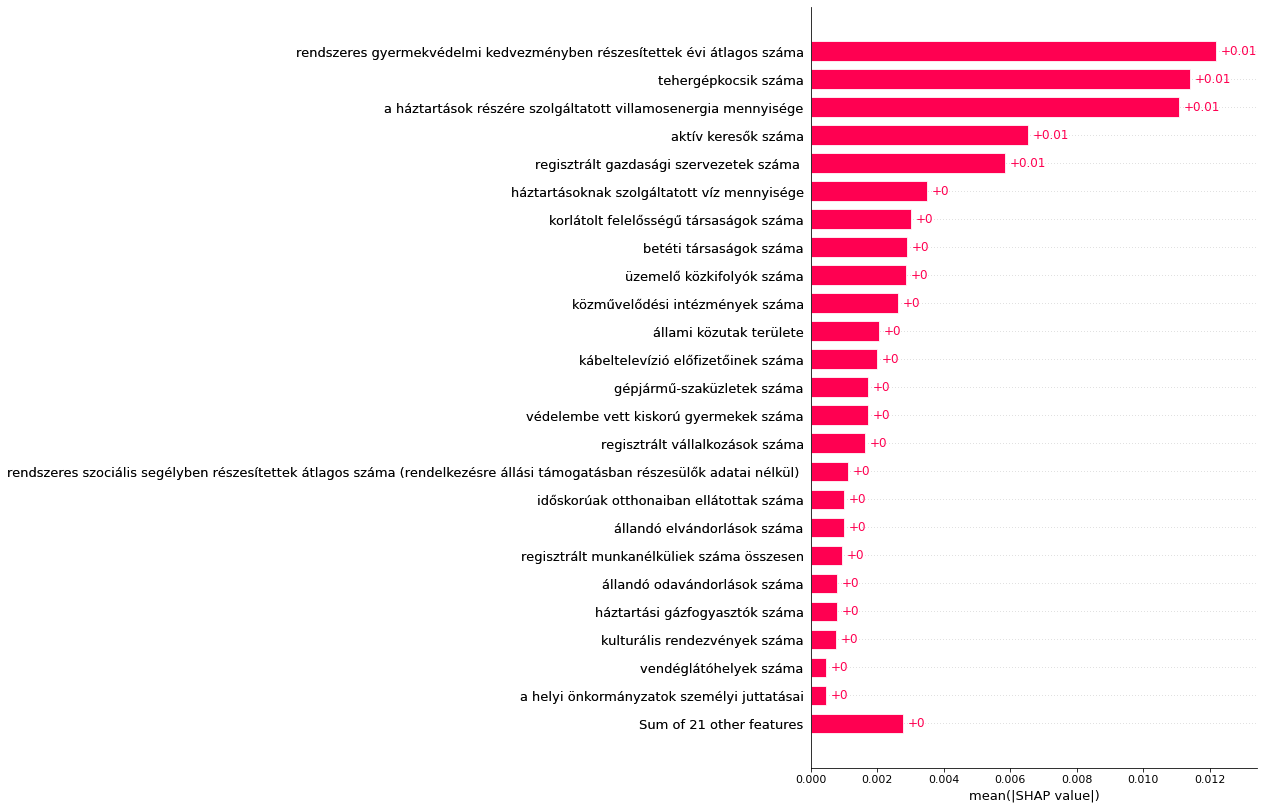

In [ ]:
shap.plots.bar(shap_values_sok_valt, max_display=25)

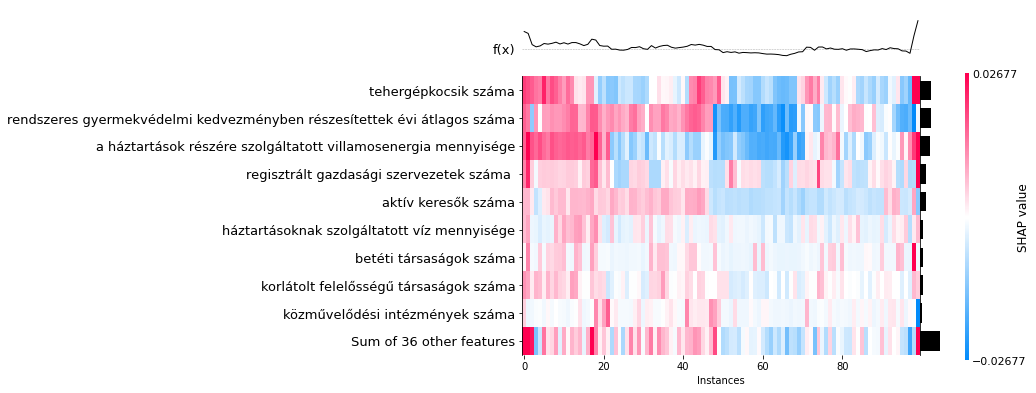

In [ ]:
shap.plots.heatmap(shap_values_sok_valt[100:200])

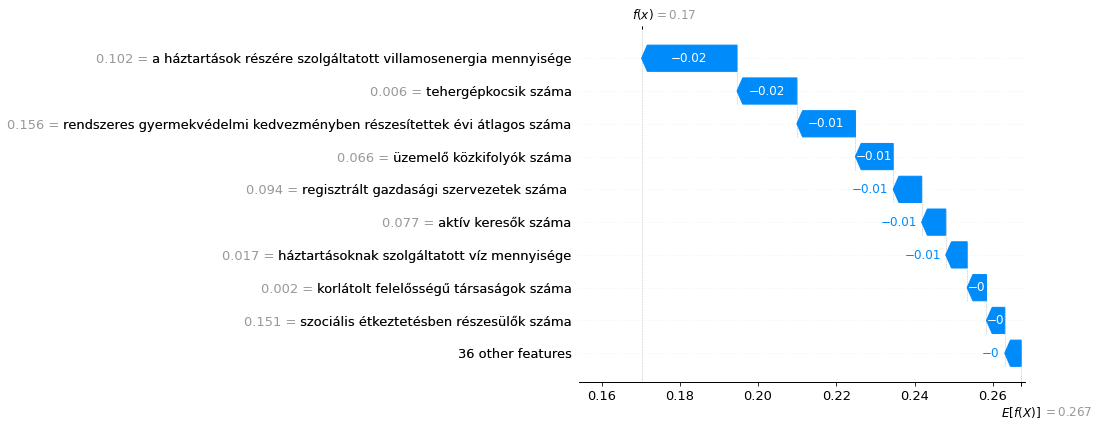

In [ ]:
shap.plots.waterfall(shap_values_sok_valt[170])

In [ ]:
shap.initjs()
explainer_sok_valt_tree = shap.TreeExplainer(xgb_model_sok_valt)
shap_values_sok_valt_tree = explainer_sok_valt_tree.shap_values(X_test_sok_valt)
def p(j):
    return(shap.force_plot(explainer_sok_valt_tree.expected_value, shap_values_sok_valt_tree[j,:], X_test_sok_valt.iloc[j,:]))
p(0)

The final prediction is  0.17024058


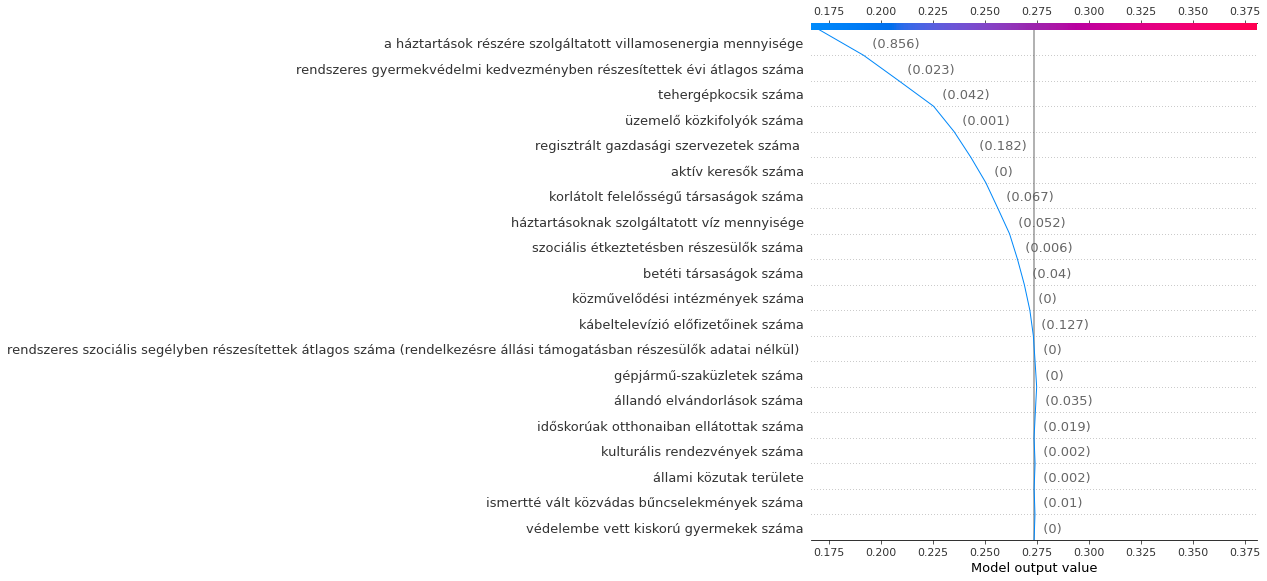

In [ ]:
expected_value = explainer_sok_valt_tree.expected_value
#print("The expected value is ", expected_value)
print("The final prediction is ", xgb_model_sok_valt.predict(X_test_sok_valt)[170])
shap_values_ex = explainer_sok_valt_tree.shap_values(X_test_sok_valt)[170]
shap.decision_plot(expected_value, shap_values_ex, X_test_sok_valt)

# **2. Modell betanítás**

## Eredeti adaton

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cross_all[feature_names], cross_all['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

[15:11:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_test)

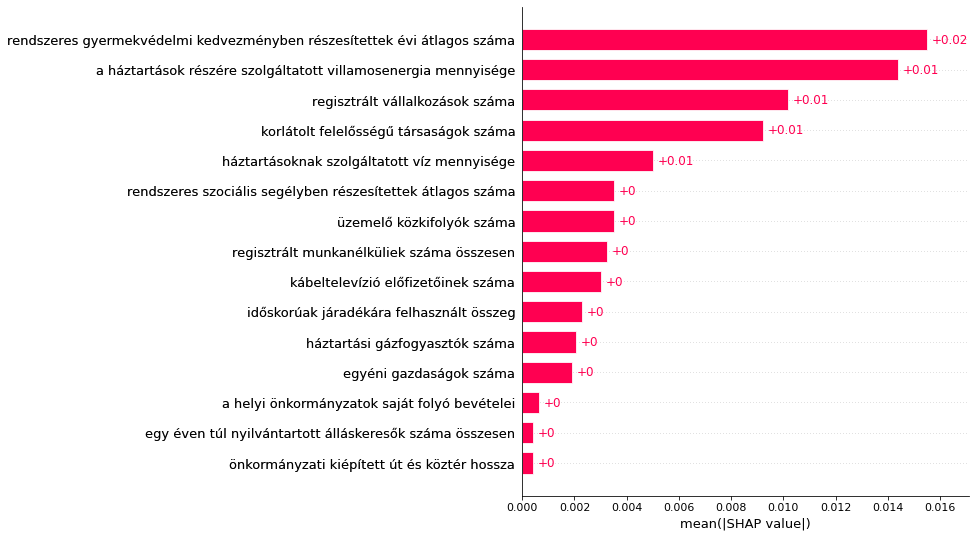

In [ ]:
shap.plots.bar(shap_values_xgb, max_display=15)

https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html#Cohort-bar-plot

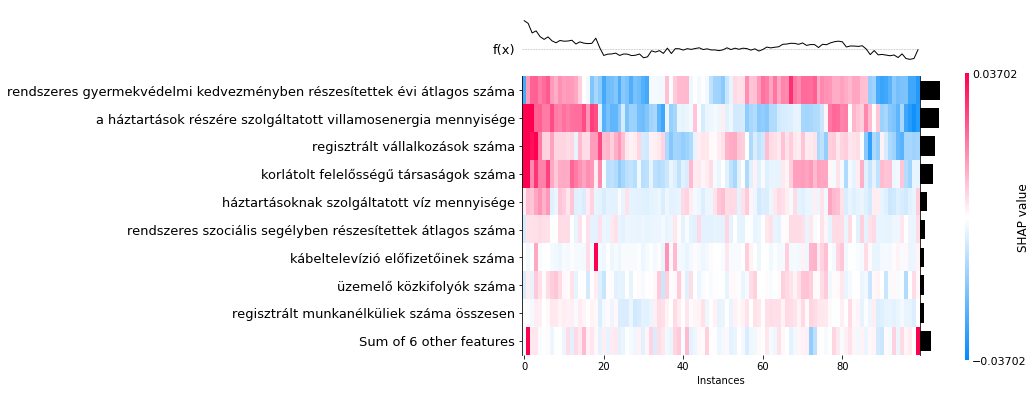

In [ ]:
shap.plots.heatmap(shap_values_xgb[100:200])

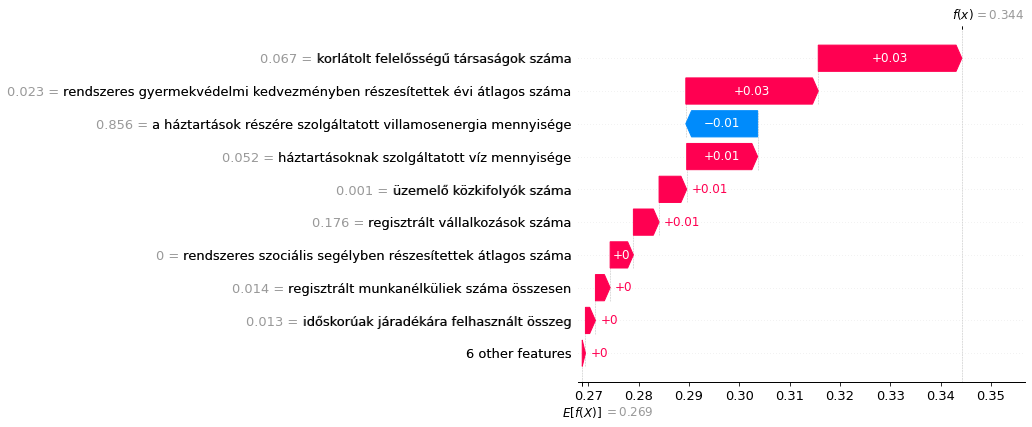

In [ ]:
shap.plots.waterfall(shap_values_xgb[0])

In [ ]:
X_test

label            a helyi önkormányzatok saját folyó bevételei  \
geoname                                                         
Üröm                                                42.100400   
Nagytevel                                           52.912959   
Sukoró                                             100.257882   
Sükösd                                              19.358506   
Zalaszentbalázs                                     67.684663   
...                                                       ...   
Sima                                                42.843750   
Újtelek                                             15.992288   
Hét                                                 43.623482   
Királd                                              22.479532   
Kaskantyú                                           18.648328   

label            a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                           
Üröm                                                      0.855821                
Nagytevel                                                 1.135397                
Sukoró                                                    1.582862                
Sükösd                                                    1.113679                
Zalaszentbalázs                                           0.971779                
...                                                            ...                
Sima                                                      1.656250                
Újtelek                                                   1.203085                
Hét                                                       0.611336                
Királd                                                    0.819883                
Kaskantyú                                                 1.382956                

label            egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                                    
Üröm                                                      0.002900         
Nagytevel                                                 0.015474         
Sukoró                                                    0.004850         
Sükösd                                                    0.020693         
Zalaszentbalázs                                           0.017178         
...                                                            ...         
Sima                                                      0.000000         
Újtelek                                                   0.017995         
Hét                                                       0.026316         
Királd                                                    0.037427         
Kaskantyú                                                 0.018339         

label            egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                                    
Üröm                            0.007043                        0.350780   
Nagytevel                       0.052224                        0.295938   
Sukoró                          0.048504                        0.730800   
Sükösd                          0.124966                        0.301532   
Zalaszentbalázs                 0.239264                        0.182822   
...                                  ...                             ...   
Sima                            0.093750                        0.000000   
Újtelek                         0.257069                        0.552699   
Hét                             0.204453                        0.348178   
Királd                          0.092398                        0.150877   
Kaskantyú                       0.211435                        0.283711   

label            háztartásoknak szolgáltatott víz mennyisége  \
geoname                         

In [ ]:
X_test.head()

label            a helyi önkormányzatok saját folyó bevételei  \
geoname                                                         
Üröm                                                42.100400   
Nagytevel                                           52.912959   
Sukoró                                             100.257882   
Sükösd                                              19.358506   
Zalaszentbalázs                                     67.684663   

label            a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                           
Üröm                                                      0.855821                
Nagytevel                                                 1.135397                
Sukoró                                                    1.582862                
Sükösd                                                    1.113679                
Zalaszentbalázs                                           0.971779                

label            egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                                    
Üröm                                                      0.002900         
Nagytevel                                                 0.015474         
Sukoró                                                    0.004850         
Sükösd                                                    0.020693         
Zalaszentbalázs                                           0.017178         

label            egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                                    
Üröm                            0.007043                        0.350780   
Nagytevel                       0.052224                        0.295938   
Sukoró                          0.048504                        0.730800   
Sükösd                          0.124966                        0.301532   
Zalaszentbalázs                 0.239264                        0.182822   

label            háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                        
Üröm                                                0.051650   
Nagytevel                                           0.025145   
Sukoró                                              0.069523   
Sükösd                                              0.034399   
Zalaszentbalázs                                     0.024540   

label            időskorúak járadékára felhasznált összeg  \
geoname                                                     
Üröm                                             0.012567   
Nagytevel                                        0.000000   
Sukoró                                           0.299111   
Sükösd                                           0.126041   
Zalaszentbalázs                                  0.001227   

label            korlátolt felelősségű társaságok száma  \
geoname                                                   
Üröm                                           0.066980   
Nagytevel                                      0.015474   
Sukoró                                         0.043654   
Sükösd                                         0.014243   
Zalaszentbalázs                                0.011043   

label            kábeltelevízió előfizetőinek száma  \
geoname                                               
Üröm                                       0.127054   
Nagytevel                                  0.005803   
Sukoró                                     0.101051   
Sükösd                                     0.121473   
Zalaszentbalázs                            0.112883   

label            regisztrált munkanélküliek száma összesen  \
geoname                                                      
Üröm                                              0.013534   
Nagytevel                        

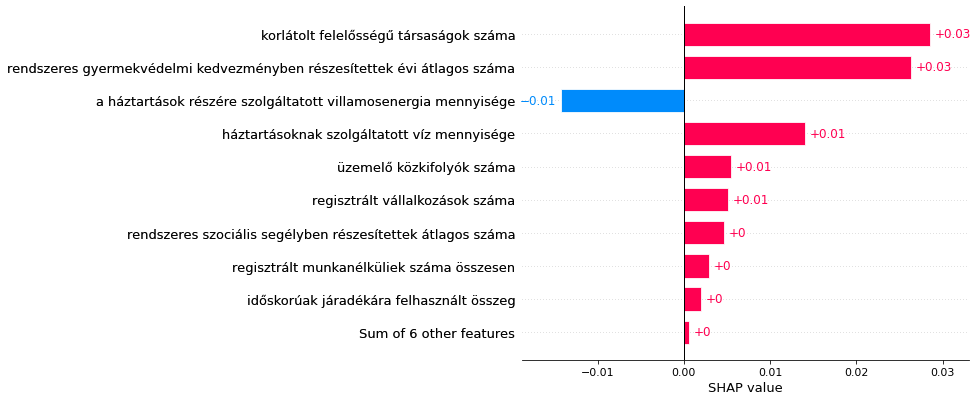

In [ ]:
shap.plots.bar(shap_values_xgb[0])

In [ ]:
shap.initjs()
explainer_tree = shap.TreeExplainer(xgb_model)
shap_values_tree = explainer_tree.shap_values(X_test)
def p(j):
    return(shap.force_plot(explainer_tree.expected_value, shap_values_tree[j,:], X_test.iloc[j,:]))
p(0)

The final prediction is  0.3442042


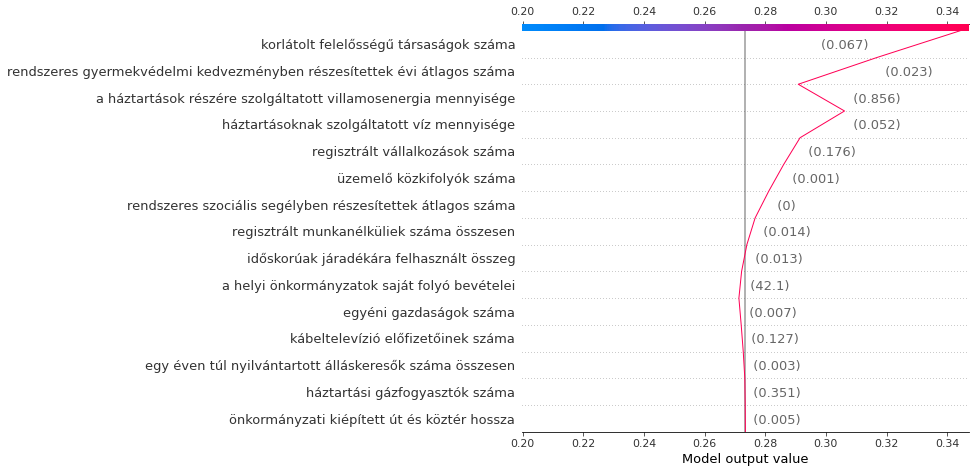

In [ ]:
expected_value = explainer_tree.expected_value
#print("The expected value is ", expected_value)
print("The final prediction is ", xgb_model.predict(X_test)[0])
shap_values_0 = explainer_tree.shap_values(X_test)[0]
shap.decision_plot(expected_value, shap_values_0, X_test)

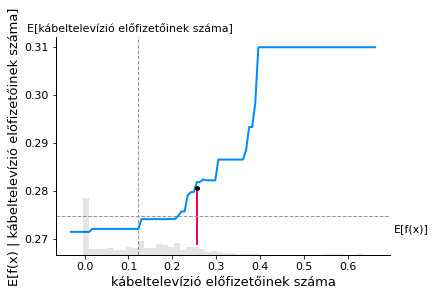

In [ ]:
sample_ind = 14

# make a standard partial dependence plot with a single SHAP value overlaid
fig,ax = shap.partial_dependence_plot(
    "kábeltelevízió előfizetőinek száma", xgb_model.predict, X_test, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False,
    shap_values=shap_values_xgb[sample_ind:sample_ind+1,:]
)

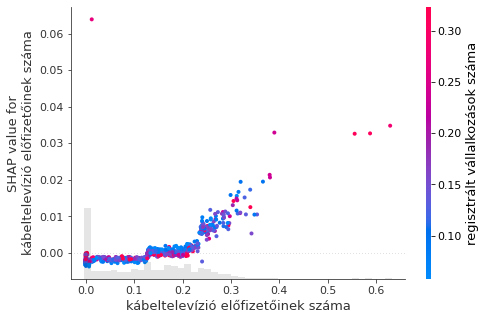

In [ ]:
shap.plots.scatter(shap_values_xgb[:,"kábeltelevízió előfizetőinek száma"], color=shap_values_xgb)

# **3. Transzformációk**

## Boros adat

In [ ]:
df_wine = pd.read_csv('/content/winequality-red.csv')

In [ ]:
df_wine['quality'] = df_wine['quality'].astype(int)
df_wine.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [ ]:
a = df_wine['quality'].unique()
print(a)

[5 6 7 4 8 3]


In [ ]:
features_wine = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Y_wine = df_wine['quality']
X_wine =  df_wine[features_wine]
X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(X_wine, Y_wine, test_size = 0.2, random_state = 1234)
xgb_model_wine = xgb.XGBRegressor(random_state=42)
xgb_model_wine.fit(X_train_wine, Y_train_wine)

[15:12:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_wine = shap.Explainer(xgb_model_wine)
shap_values_wine = explainer_wine(X_test_wine)

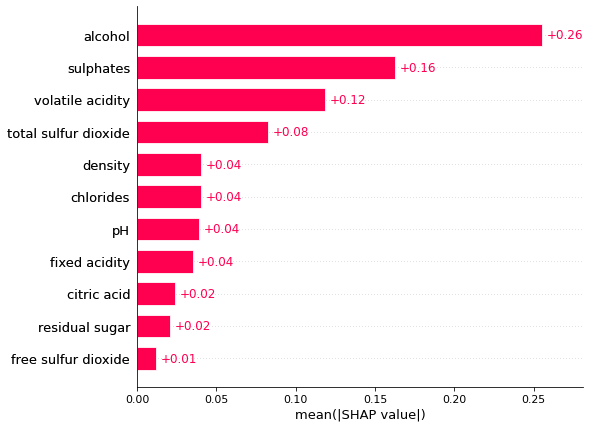

In [ ]:
shap.plots.bar(shap_values_wine, max_display=15)

[15:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


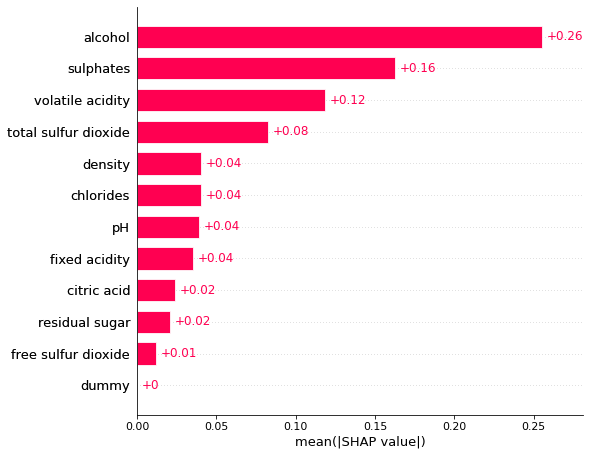

In [ ]:
# változó másolat másnéven
df_wine_mod = df_wine.copy()
df_wine_mod['dummy'] = df_wine_mod['alcohol']
features_wine = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'dummy']

Y_wine = df_wine_mod['quality']
X_wine =  df_wine_mod[features_wine]

X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(X_wine, Y_wine, test_size = 0.2, random_state = 1234)
xgb_model_wine = xgb.XGBRegressor(random_state=42)
xgb_model_wine.fit(X_train_wine, Y_train_wine)

explainer_wine = shap.Explainer(xgb_model_wine)
shap_values_wine = explainer_wine(X_test_wine)

shap.plots.bar(shap_values_wine, max_display=15)

[15:29:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


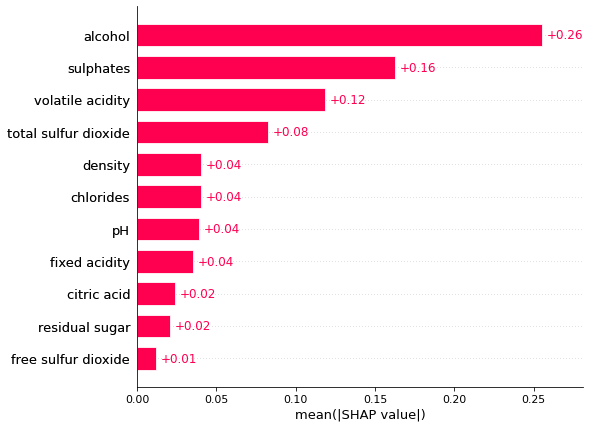

In [ ]:
# változó kétszeresen
df_wine_mod = df_wine.copy()
df_wine_mod['alcohol'] = df_wine_mod['alcohol'] * 2
features_wine = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

Y_wine = df_wine_mod['quality']
X_wine =  df_wine_mod[features_wine]

X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(X_wine, Y_wine, test_size = 0.2, random_state = 1234)
xgb_model_wine = xgb.XGBRegressor(random_state=42)
xgb_model_wine.fit(X_train_wine, Y_train_wine)

explainer_wine = shap.Explainer(xgb_model_wine)
shap_values_wine = explainer_wine(X_test_wine)

shap.plots.bar(shap_values_wine, max_display=15)

[15:32:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


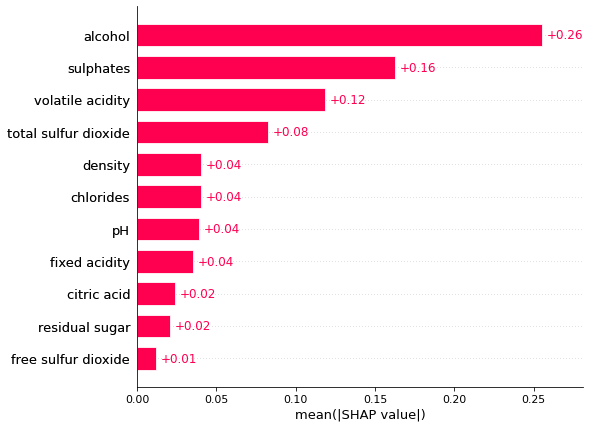

In [ ]:
# változó skálázva
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

df_wine_mod = df_wine.copy()
df_wine_mod[['alcohol']] =  mms.fit_transform(df_wine_mod[['alcohol']])
features_wine = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

Y_wine = df_wine_mod['quality']
X_wine =  df_wine_mod[features_wine]

X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(X_wine, Y_wine, test_size = 0.2, random_state = 1234)
xgb_model_wine = xgb.XGBRegressor(random_state=42)
xgb_model_wine.fit(X_train_wine, Y_train_wine)

explainer_wine = shap.Explainer(xgb_model_wine)
shap_values_wine = explainer_wine(X_test_wine)

shap.plots.bar(shap_values_wine, max_display=15)

[15:34:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


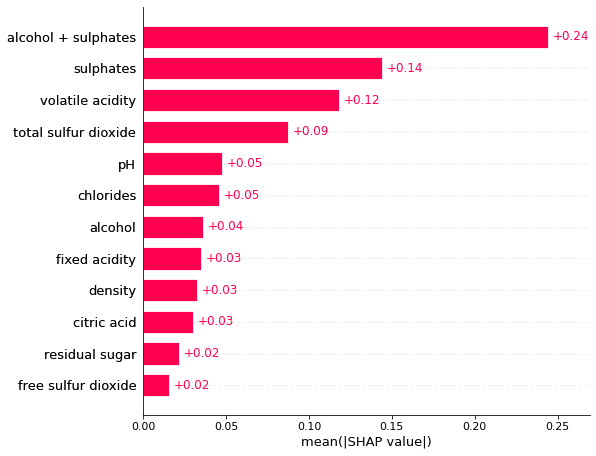

In [ ]:
# változók összeadva

df_wine_mod = df_wine.copy()
df_wine_mod['alcohol + sulphates'] =  df_wine_mod['alcohol'] + df_wine_mod['sulphates']
features_wine = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol','alcohol + sulphates']

Y_wine = df_wine_mod['quality']
X_wine =  df_wine_mod[features_wine]

X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(X_wine, Y_wine, test_size = 0.2, random_state = 1234)
xgb_model_wine = xgb.XGBRegressor(random_state=42)
xgb_model_wine.fit(X_train_wine, Y_train_wine)

explainer_wine = shap.Explainer(xgb_model_wine)
shap_values_wine = explainer_wine(X_test_wine)

shap.plots.bar(shap_values_wine, max_display=15)

[15:37:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


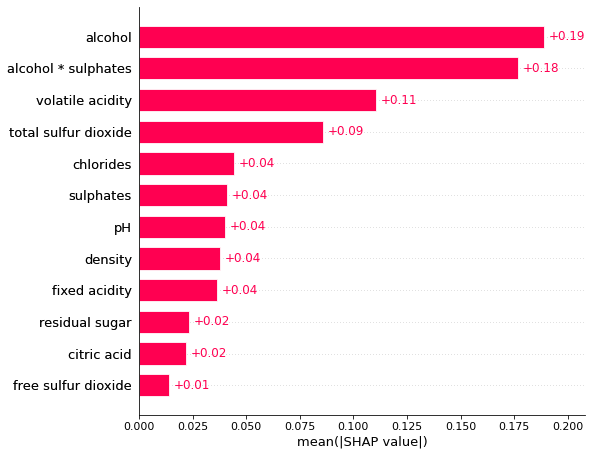

In [ ]:
# változók összeszorozva

df_wine_mod = df_wine.copy()
df_wine_mod['alcohol * sulphates'] =  df_wine_mod['alcohol'] * df_wine_mod['sulphates']
features_wine = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol','alcohol * sulphates']

Y_wine = df_wine_mod['quality']
X_wine =  df_wine_mod[features_wine]

X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(X_wine, Y_wine, test_size = 0.2, random_state = 1234)
xgb_model_wine = xgb.XGBRegressor(random_state=42)
xgb_model_wine.fit(X_train_wine, Y_train_wine)

explainer_wine = shap.Explainer(xgb_model_wine)
shap_values_wine = explainer_wine(X_test_wine)

shap.plots.bar(shap_values_wine, max_display=15)

[15:38:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


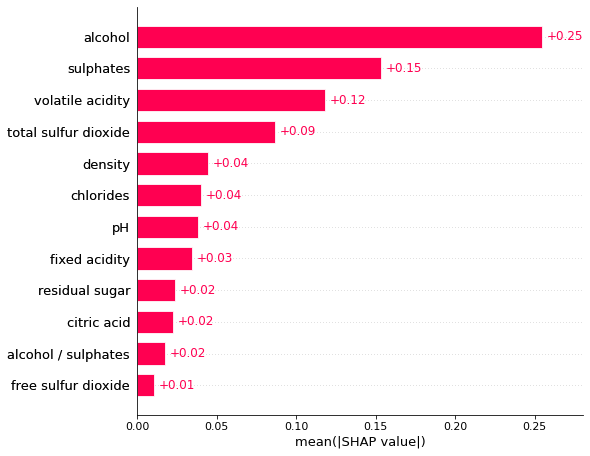

In [ ]:
# változók egymással osztva

df_wine_mod = df_wine.copy()
df_wine_mod['alcohol / sulphates'] =  df_wine_mod['alcohol'] / df_wine_mod['sulphates']
features_wine = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol','alcohol / sulphates']

Y_wine = df_wine_mod['quality']
X_wine =  df_wine_mod[features_wine]

X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(X_wine, Y_wine, test_size = 0.2, random_state = 1234)
xgb_model_wine = xgb.XGBRegressor(random_state=42)
xgb_model_wine.fit(X_train_wine, Y_train_wine)

explainer_wine = shap.Explainer(xgb_model_wine)
shap_values_wine = explainer_wine(X_test_wine)

shap.plots.bar(shap_values_wine, max_display=15)

## Oszlop szorozva 2-vel

In [ ]:
cross_all_2szer =  cross_all.copy()
cross_all_2szer['a háztartások részére szolgáltatott villamosenergia mennyisége_2szer'] = cross_all_2szer['a háztartások részére szolgáltatott villamosenergia mennyisége']*2
cross_all_2szer.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                        0.090715                        0.262516   
Abaliget                   0.056507                        0.000000   
Abasár                     0.122058                        0.349023   
Abaújalpár                 0.293333                        0.253333   
Abaújkér                   0.124821                        0.170732   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                            0.026744   
Abaliget                                       0.034247   
Abasár                                         0.032708   
Abaújalpár                                     0.013333   
Abaújkér                                       0.018651   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                         0.180573   
Abaliget                                    0.000000   
Abasár                                      0.129637   
Abaújalpár                                  0.000000   
Abaújkér                                    0.000000   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                       0.014549   
Abaliget                                  0.029110   
Abasár                                    0.023135   
Abaújalpár                                0.066667   
Abaújkér                                  0.011478   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                   0.128156   
Abaliget                              0.018836   
Abasár                                0.166733   
Abaújalpár                            0.000000   
Abaújkér                              0.071736   

label       regisztrált munkanélküliek száma összesen  \
geoname                                                 
Aba                                          0.056055   
Abaliget                                     0.099315   
Abasár                                       0.060630   
Abaújalpár                                   0.253333   
Abaújkér                                     0.114778   

label       regisztrált vállalkozások száma  \
geoname                                       
Aba  

In [ ]:
feature_names = list(cross_all_2szer.columns)
feature_names.pop(-4)

'személygépkocsik száma'

In [ ]:
X_train_2szer, X_test_2szer, y_train_2szer, y_test_2szer = train_test_split(cross_all_2szer[feature_names], cross_all_2szer['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_2szer = xgb.XGBRegressor(random_state=42)
xgb_model_2szer.fit(X_train_2szer, y_train_2szer)

[12:29:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_2szer = shap.Explainer(xgb_model_2szer, X_train_2szer)
shap_values_2szer = explainer_2szer(X_test_2szer)

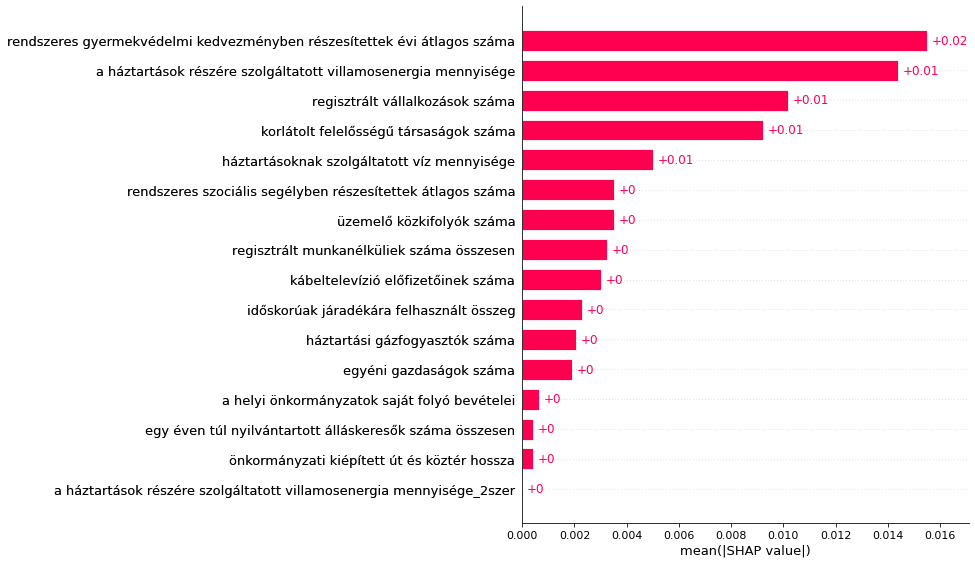

In [ ]:
shap.plots.bar(shap_values_2szer, max_display=20)

In [ ]:
cross_all_2szer =  cross_all.copy()
cross_all_2szer[['üzemelő közkifolyók száma_2szer', 'egyéni gazdaságok száma_2szer', 'a háztartások részére szolgáltatott villamosenergia mennyisége_2szer', 'háztartási gázfogyasztók száma_2szer', 'időskorúak járadékára felhasznált összeg_2szer']] = cross_all_2szer[['üzemelő közkifolyók száma', 'egyéni gazdaságok száma', 'a háztartások részére szolgáltatott villamosenergia mennyisége', 'háztartási gázfogyasztók száma', 'időskorúak járadékára felhasznált összeg']]*2
cross_all_2szer.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                        0.090715                        0.262516   
Abaliget                   0.056507                        0.000000   
Abasár                     0.122058                        0.349023   
Abaújalpár                 0.293333                        0.253333   
Abaújkér                   0.124821                        0.170732   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                            0.026744   
Abaliget                                       0.034247   
Abasár                                         0.032708   
Abaújalpár                                     0.013333   
Abaújkér                                       0.018651   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                         0.180573   
Abaliget                                    0.000000   
Abasár                                      0.129637   
Abaújalpár                                  0.000000   
Abaújkér                                    0.000000   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                       0.014549   
Abaliget                                  0.029110   
Abasár                                    0.023135   
Abaújalpár                                0.066667   
Abaújkér                                  0.011478   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                   0.128156   
Abaliget                              0.018836   
Abasár                                0.166733   
Abaújalpár                            0.000000   
Abaújkér                              0.071736   

label       regisztrált munkanélküliek száma összesen  ...  \
geoname                                                ...   
Aba                                          0.056055  ...   
Abaliget                                     0.099315  ...   
Abasár                                       0.060630  ...   
Abaújalpár                                   0.253333  ...   
Abaújkér                                     0.114778  ...   

label       rendszeres gyermekvédelmi kedvezményben részesítette

In [ ]:
feature_names = list(cross_all_2szer.columns)
feature_names.pop(-8)

'személygépkocsik száma'

In [ ]:
X_train_2szer, X_test_2szer, y_train_2szer, y_test_2szer = train_test_split(cross_all_2szer[feature_names], cross_all_2szer['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_2szer = xgb.XGBRegressor(random_state=42)
xgb_model_2szer.fit(X_train_2szer, y_train_2szer)

[12:29:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_2szer = shap.Explainer(xgb_model_2szer, X_train_2szer)
shap_values_2szer = explainer_2szer(X_test_2szer)

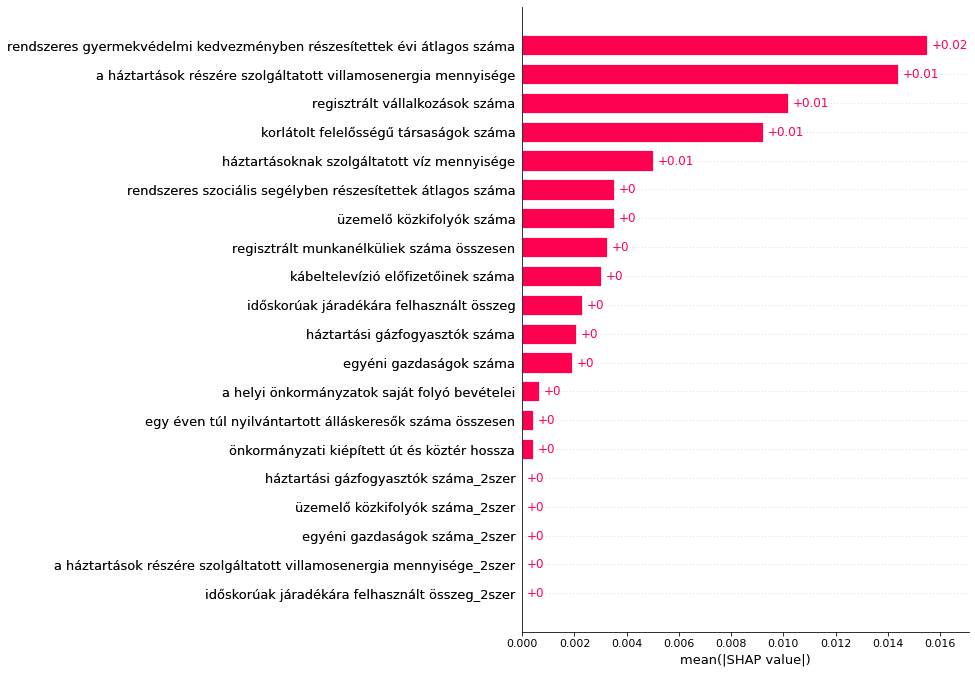

In [ ]:
shap.plots.bar(shap_values_2szer, max_display=25)

## Oszlop skálázva

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
mms = MinMaxScaler()

cross_all_scaled =  cross_all.copy()
cross_all_scaled[['a háztartások részére szolgáltatott villamosenergia mennyisége_skálázott']] = mms.fit_transform(cross_all_scaled[['a háztartások részére szolgáltatott villamosenergia mennyisége']])
cross_all_scaled.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                        0.090715                        0.262516   
Abaliget                   0.056507                        0.000000   
Abasár                     0.122058                        0.349023   
Abaújalpár                 0.293333                        0.253333   
Abaújkér                   0.124821                        0.170732   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                            0.026744   
Abaliget                                       0.034247   
Abasár                                         0.032708   
Abaújalpár                                     0.013333   
Abaújkér                                       0.018651   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                         0.180573   
Abaliget                                    0.000000   
Abasár                                      0.129637   
Abaújalpár                                  0.000000   
Abaújkér                                    0.000000   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                       0.014549   
Abaliget                                  0.029110   
Abasár                                    0.023135   
Abaújalpár                                0.066667   
Abaújkér                                  0.011478   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                   0.128156   
Abaliget                              0.018836   
Abasár                                0.166733   
Abaújalpár                            0.000000   
Abaújkér                              0.071736   

label       regisztrált munkanélküliek száma összesen  \
geoname                                                 
Aba                                          0.056055   
Abaliget                                     0.099315   
Abasár                                       0.060630   
Abaújalpár                                   0.253333   
Abaújkér                                     0.114778   

label       regisztrált vállalkozások száma  \
geoname                                       
Aba  

In [ ]:
feature_names = list(cross_all_scaled.columns)
feature_names.pop(-4)

'személygépkocsik száma'

In [ ]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(cross_all_scaled[feature_names], cross_all_scaled['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_scaled = xgb.XGBRegressor(random_state=42)
xgb_model_scaled.fit(X_train_scaled, y_train_scaled)

[12:29:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_scaled = shap.Explainer(xgb_model_scaled, X_train_scaled)
shap_values_scaled = explainer_scaled(X_test_scaled)

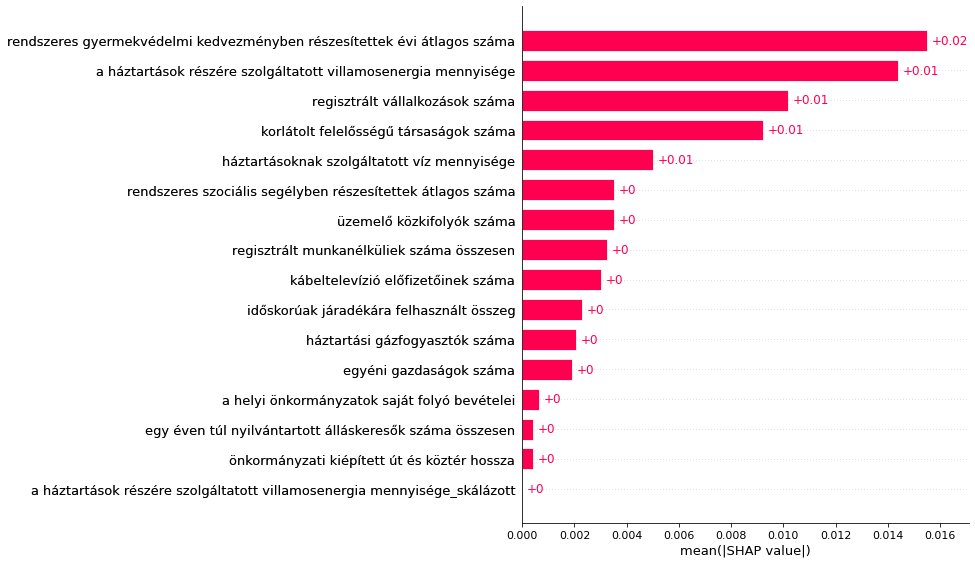

In [ ]:
shap.plots.bar(shap_values_scaled, max_display=20)

In [ ]:
mms = MinMaxScaler()

cross_all_scaled =  cross_all.copy()
cross_all_scaled[['a háztartások részére szolgáltatott villamosenergia mennyisége_skálázott', 'háztartásoknak szolgáltatott víz mennyisége_skálázott', 'korlátolt felelősségű társaságok száma_skálázott', 'kábeltelevízió előfizetőinek száma_skálázott']] = mms.fit_transform(cross_all_scaled[['a háztartások részére szolgáltatott villamosenergia mennyisége', 'háztartásoknak szolgáltatott víz mennyisége', 'korlátolt felelősségű társaságok száma', 'kábeltelevízió előfizetőinek száma']])
cross_all_scaled.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                        0.090715                        0.262516   
Abaliget                   0.056507                        0.000000   
Abasár                     0.122058                        0.349023   
Abaújalpár                 0.293333                        0.253333   
Abaújkér                   0.124821                        0.170732   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                            0.026744   
Abaliget                                       0.034247   
Abasár                                         0.032708   
Abaújalpár                                     0.013333   
Abaújkér                                       0.018651   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                         0.180573   
Abaliget                                    0.000000   
Abasár                                      0.129637   
Abaújalpár                                  0.000000   
Abaújkér                                    0.000000   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                       0.014549   
Abaliget                                  0.029110   
Abasár                                    0.023135   
Abaújalpár                                0.066667   
Abaújkér                                  0.011478   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                   0.128156   
Abaliget                              0.018836   
Abasár                                0.166733   
Abaújalpár                            0.000000   
Abaújkér                              0.071736   

label       regisztrált munkanélküliek száma összesen  \
geoname                                                 
Aba                                          0.056055   
Abaliget                                     0.099315   
Abasár                                       0.060630   
Abaújalpár                                   0.253333   
Abaújkér                                     0.114778   

label       regisztrált vállalkozások száma  \
geoname                                       
Aba  

In [ ]:
feature_names = list(cross_all_scaled.columns)
feature_names.pop(-7)

'személygépkocsik száma'

In [ ]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(cross_all_scaled[feature_names], cross_all_scaled['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_scaled = xgb.XGBRegressor(random_state=42)
xgb_model_scaled.fit(X_train_scaled, y_train_scaled)

[12:29:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_scaled = shap.Explainer(xgb_model_scaled, X_train_scaled)
shap_values_scaled = explainer_scaled(X_test_scaled)

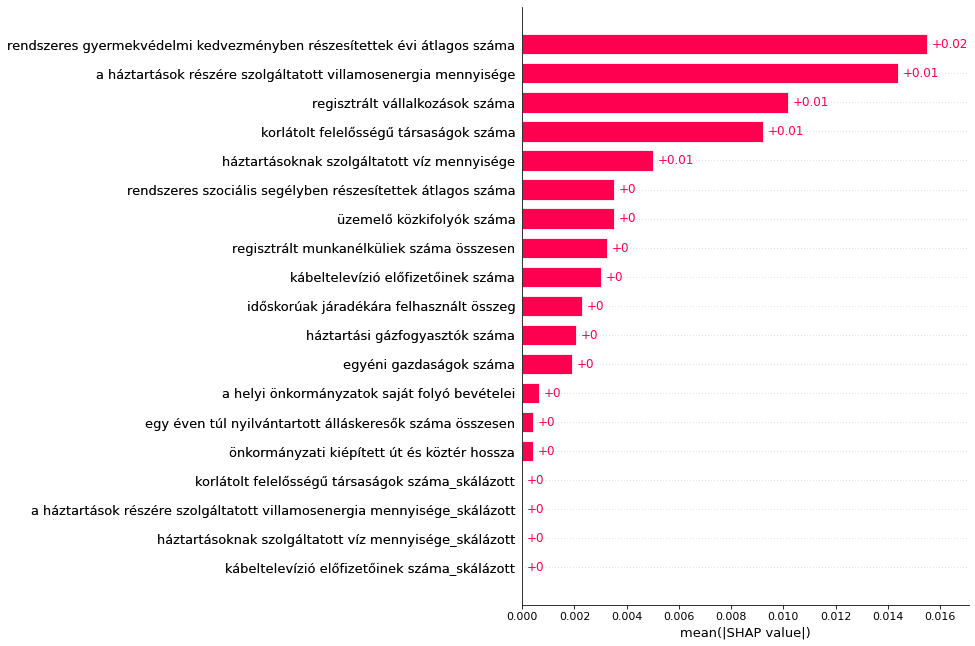

In [ ]:
shap.plots.bar(shap_values_scaled, max_display=20)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
ss = StandardScaler()

cross_all_scaled =  cross_all.copy()
cross_all_scaled[['a háztartások részére szolgáltatott villamosenergia mennyisége_skálázott']] = ss.fit_transform(cross_all_scaled[['a háztartások részére szolgáltatott villamosenergia mennyisége']])
cross_all_scaled.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                        0.090715                        0.262516   
Abaliget                   0.056507                        0.000000   
Abasár                     0.122058                        0.349023   
Abaújalpár                 0.293333                        0.253333   
Abaújkér                   0.124821                        0.170732   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                            0.026744   
Abaliget                                       0.034247   
Abasár                                         0.032708   
Abaújalpár                                     0.013333   
Abaújkér                                       0.018651   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                         0.180573   
Abaliget                                    0.000000   
Abasár                                      0.129637   
Abaújalpár                                  0.000000   
Abaújkér                                    0.000000   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                       0.014549   
Abaliget                                  0.029110   
Abasár                                    0.023135   
Abaújalpár                                0.066667   
Abaújkér                                  0.011478   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                   0.128156   
Abaliget                              0.018836   
Abasár                                0.166733   
Abaújalpár                            0.000000   
Abaújkér                              0.071736   

label       regisztrált munkanélküliek száma összesen  \
geoname                                                 
Aba                                          0.056055   
Abaliget                                     0.099315   
Abasár                                       0.060630   
Abaújalpár                                   0.253333   
Abaújkér                                     0.114778   

label       regisztrált vállalkozások száma  \
geoname                                       
Aba  

In [ ]:
feature_names = list(cross_all_scaled.columns)
feature_names.pop(-4)

'személygépkocsik száma'

In [ ]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(cross_all_scaled[feature_names], cross_all_scaled['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_scaled = xgb.XGBRegressor(random_state=42)
xgb_model_scaled.fit(X_train_scaled, y_train_scaled)

[12:29:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_scaled = shap.Explainer(xgb_model_scaled, X_train_scaled)
shap_values_scaled = explainer_scaled(X_test_scaled)

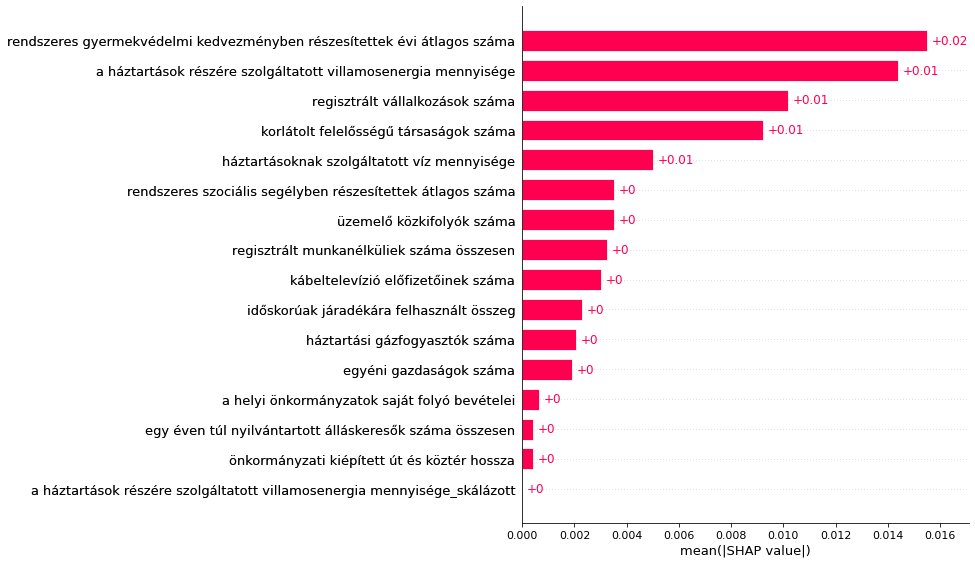

In [ ]:
shap.plots.bar(shap_values_scaled, max_display=20)

## Oszlopok összeadva

In [ ]:
cross_all_osszeg =  cross_all.copy()
cross_all_osszeg['munkanélküli + vállalkozás'] = cross_all_osszeg['regisztrált munkanélküliek száma összesen'] + cross_all_osszeg['regisztrált vállalkozások száma']
cross_all_osszeg.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                        0.090715                        0.262516   
Abaliget                   0.056507                        0.000000   
Abasár                     0.122058                        0.349023   
Abaújalpár                 0.293333                        0.253333   
Abaújkér                   0.124821                        0.170732   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                            0.026744   
Abaliget                                       0.034247   
Abasár                                         0.032708   
Abaújalpár                                     0.013333   
Abaújkér                                       0.018651   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                         0.180573   
Abaliget                                    0.000000   
Abasár                                      0.129637   
Abaújalpár                                  0.000000   
Abaújkér                                    0.000000   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                       0.014549   
Abaliget                                  0.029110   
Abasár                                    0.023135   
Abaújalpár                                0.066667   
Abaújkér                                  0.011478   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                   0.128156   
Abaliget                              0.018836   
Abasár                                0.166733   
Abaújalpár                            0.000000   
Abaújkér                              0.071736   

label       regisztrált munkanélküliek száma összesen  \
geoname                                                 
Aba                                          0.056055   
Abaliget                                     0.099315   
Abasár                                       0.060630   
Abaújalpár                                   0.253333   
Abaújkér                                     0.114778   

label       regisztrált vállalkozások száma  \
geoname                                       
Aba  

In [ ]:
feature_names_osszeg = list(cross_all_osszeg.columns)
feature_names_osszeg.pop(-4)

'személygépkocsik száma'

In [ ]:
X_train_osszeg, X_test_osszeg, y_train_osszeg, y_test_osszeg = train_test_split(cross_all_osszeg[feature_names_osszeg], cross_all_osszeg['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_osszeg = xgb.XGBRegressor(random_state=42)
xgb_model_osszeg.fit(X_train_osszeg, y_train_osszeg)

[12:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_osszeg = shap.Explainer(xgb_model_osszeg, X_train_osszeg)
shap_values_osszeg = explainer_osszeg(X_test_osszeg)

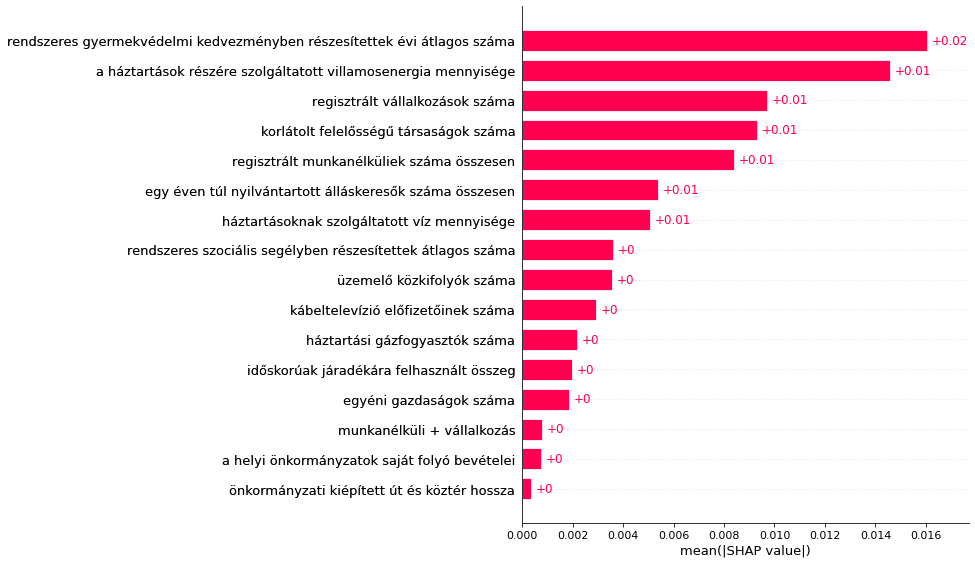

In [ ]:
shap.plots.bar(shap_values_osszeg, max_display=20)

In [ ]:
cross_all_osszeg =  cross_all.copy()
cross_all_osszeg['áram + önkorm_bevétel'] = cross_all_osszeg['a háztartások részére szolgáltatott villamosenergia mennyisége'] + cross_all_osszeg['a helyi önkormányzatok saját folyó bevételei']
cross_all_osszeg.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                        0.090715                        0.262516   
Abaliget                   0.056507                        0.000000   
Abasár                     0.122058                        0.349023   
Abaújalpár                 0.293333                        0.253333   
Abaújkér                   0.124821                        0.170732   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                            0.026744   
Abaliget                                       0.034247   
Abasár                                         0.032708   
Abaújalpár                                     0.013333   
Abaújkér                                       0.018651   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                         0.180573   
Abaliget                                    0.000000   
Abasár                                      0.129637   
Abaújalpár                                  0.000000   
Abaújkér                                    0.000000   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                       0.014549   
Abaliget                                  0.029110   
Abasár                                    0.023135   
Abaújalpár                                0.066667   
Abaújkér                                  0.011478   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                   0.128156   
Abaliget                              0.018836   
Abasár                                0.166733   
Abaújalpár                            0.000000   
Abaújkér                              0.071736   

label       regisztrált munkanélküliek száma összesen  \
geoname                                                 
Aba                                          0.056055   
Abaliget                                     0.099315   
Abasár                                       0.060630   
Abaújalpár                                   0.253333   
Abaújkér                                     0.114778   

label       regisztrált vállalkozások száma  \
geoname                                       
Aba  

In [ ]:
feature_names_osszeg = list(cross_all_osszeg.columns)
feature_names_osszeg.pop(-4)

'személygépkocsik száma'

In [ ]:
X_train_osszeg, X_test_osszeg, y_train_osszeg, y_test_osszeg = train_test_split(cross_all_osszeg[feature_names_osszeg], cross_all_osszeg['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_osszeg = xgb.XGBRegressor(random_state=42)
xgb_model_osszeg.fit(X_train_osszeg, y_train_osszeg)

[12:29:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_osszeg = shap.Explainer(xgb_model_osszeg, X_train_osszeg)
shap_values_osszeg = explainer_osszeg(X_test_osszeg)

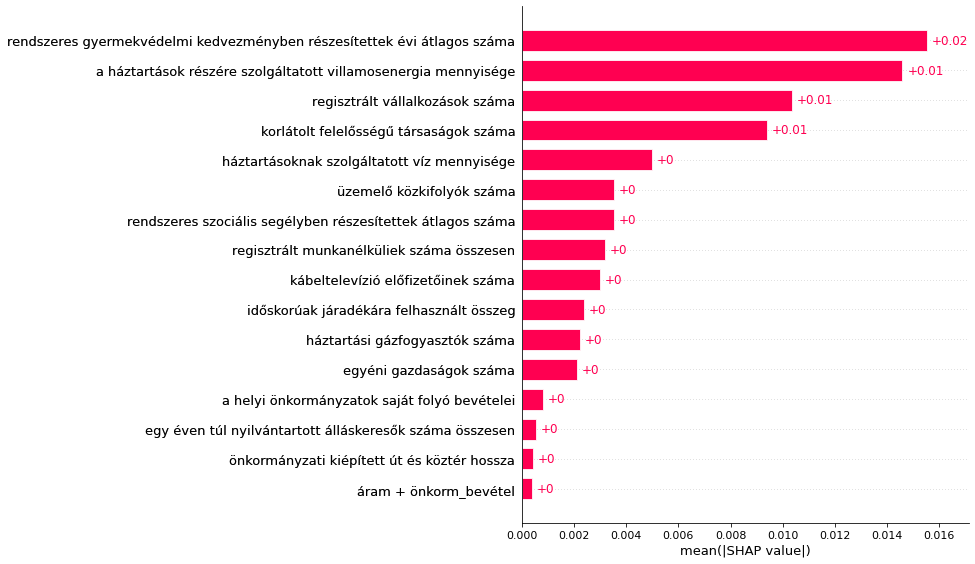

In [ ]:
shap.plots.bar(shap_values_osszeg, max_display=20)

In [ ]:
cross_all_osszeg =  cross_all.copy()
cross_all_osszeg['sorösszeg'] = cross_all_osszeg.sum(axis=1)
cross_all_osszeg.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                        0.090715                        0.262516   
Abaliget                   0.056507                        0.000000   
Abasár                     0.122058                        0.349023   
Abaújalpár                 0.293333                        0.253333   
Abaújkér                   0.124821                        0.170732   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                            0.026744   
Abaliget                                       0.034247   
Abasár                                         0.032708   
Abaújalpár                                     0.013333   
Abaújkér                                       0.018651   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                         0.180573   
Abaliget                                    0.000000   
Abasár                                      0.129637   
Abaújalpár                                  0.000000   
Abaújkér                                    0.000000   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                       0.014549   
Abaliget                                  0.029110   
Abasár                                    0.023135   
Abaújalpár                                0.066667   
Abaújkér                                  0.011478   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                   0.128156   
Abaliget                              0.018836   
Abasár                                0.166733   
Abaújalpár                            0.000000   
Abaújkér                              0.071736   

label       regisztrált munkanélküliek száma összesen  \
geoname                                                 
Aba                                          0.056055   
Abaliget                                     0.099315   
Abasár                                       0.060630   
Abaújalpár                                   0.253333   
Abaújkér                                     0.114778   

label       regisztrált vállalkozások száma  \
geoname                                       
Aba  

In [ ]:
feature_names_osszeg = list(cross_all_osszeg.columns)
feature_names_osszeg.pop(-4)

'személygépkocsik száma'

In [ ]:
X_train_osszeg, X_test_osszeg, y_train_osszeg, y_test_osszeg = train_test_split(cross_all_osszeg[feature_names_osszeg], cross_all_osszeg['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_osszeg = xgb.XGBRegressor(random_state=42)
xgb_model_osszeg.fit(X_train_osszeg, y_train_osszeg)

[12:29:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_osszeg = shap.Explainer(xgb_model_osszeg, X_train_osszeg)
shap_values_osszeg = explainer_osszeg(X_test_osszeg)

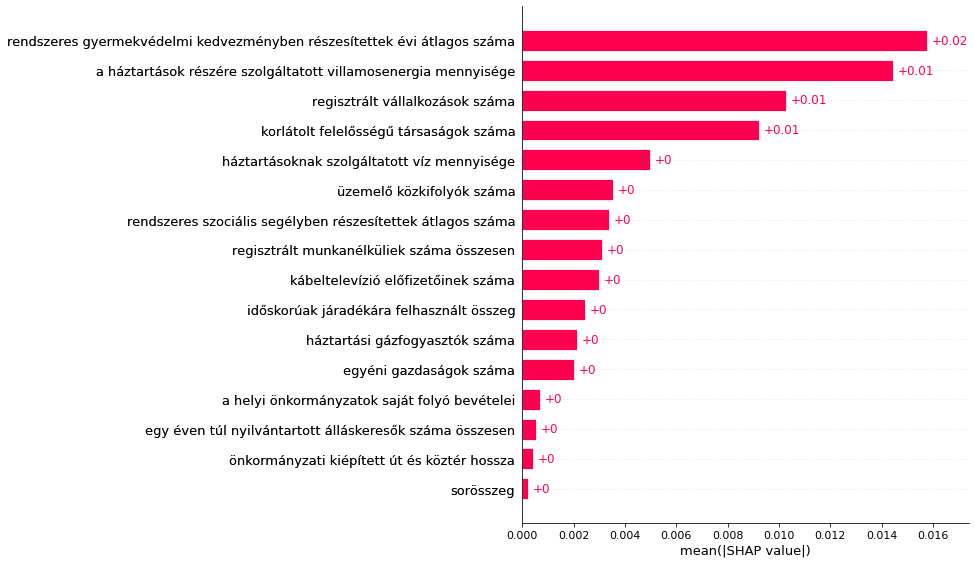

In [ ]:
shap.plots.bar(shap_values_osszeg, max_display=20)

## Oszlopok egymással osztva

### Gyermekvédelmi/áram

In [ ]:
cross_all_hanyados =  cross_all.copy()
cross_all_hanyados['gyermekvédelmi / áram'] = cross_all_hanyados['rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma'] / cross_all_hanyados['a háztartások részére szolgáltatott villamosenergia mennyisége']
cross_all_hanyados.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                        0.090715                        0.262516   
Abaliget                   0.056507                        0.000000   
Abasár                     0.122058                        0.349023   
Abaújalpár                 0.293333                        0.253333   
Abaújkér                   0.124821                        0.170732   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                            0.026744   
Abaliget                                       0.034247   
Abasár                                         0.032708   
Abaújalpár                                     0.013333   
Abaújkér                                       0.018651   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                         0.180573   
Abaliget                                    0.000000   
Abasár                                      0.129637   
Abaújalpár                                  0.000000   
Abaújkér                                    0.000000   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                       0.014549   
Abaliget                                  0.029110   
Abasár                                    0.023135   
Abaújalpár                                0.066667   
Abaújkér                                  0.011478   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                   0.128156   
Abaliget                              0.018836   
Abasár                                0.166733   
Abaújalpár                            0.000000   
Abaújkér                              0.071736   

label       regisztrált munkanélküliek száma összesen  \
geoname                                                 
Aba                                          0.056055   
Abaliget                                     0.099315   
Abasár                                       0.060630   
Abaújalpár                                   0.253333   
Abaújkér                                     0.114778   

label       regisztrált vállalkozások száma  \
geoname                                       
Aba  

In [ ]:
feature_names_hanyados = list(cross_all_hanyados.columns)
feature_names_hanyados.pop(-4)

'személygépkocsik száma'

In [ ]:
X_train_hanyados, X_test_hanyados, y_train_hanyados, y_test_hanyados = train_test_split(cross_all_hanyados[feature_names_hanyados], cross_all_hanyados['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_hanyados = xgb.XGBRegressor(random_state=42)
xgb_model_hanyados.fit(X_train_hanyados, y_train_hanyados)

[12:29:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_hanyados = shap.Explainer(xgb_model_hanyados, X_train_hanyados)
shap_values_hanyados = explainer_hanyados(X_test_hanyados)

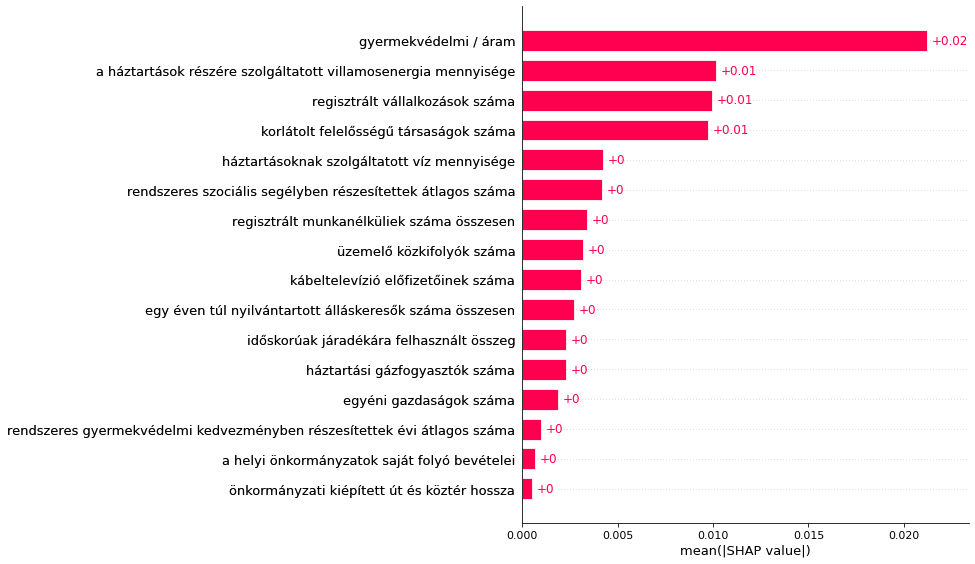

In [ ]:
shap.plots.bar(shap_values_hanyados, max_display=20)

In [ ]:
cross_all_hanyados =  cross_all.copy()
cross_all_hanyados['áram / gyermekvédelmi'] = cross_all_hanyados['a háztartások részére szolgáltatott villamosenergia mennyisége'] / cross_all_hanyados['rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma']
cross_all_hanyados.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                        0.090715                        0.262516   
Abaliget                   0.056507                        0.000000   
Abasár                     0.122058                        0.349023   
Abaújalpár                 0.293333                        0.253333   
Abaújkér                   0.124821                        0.170732   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                            0.026744   
Abaliget                                       0.034247   
Abasár                                         0.032708   
Abaújalpár                                     0.013333   
Abaújkér                                       0.018651   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                         0.180573   
Abaliget                                    0.000000   
Abasár                                      0.129637   
Abaújalpár                                  0.000000   
Abaújkér                                    0.000000   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                       0.014549   
Abaliget                                  0.029110   
Abasár                                    0.023135   
Abaújalpár                                0.066667   
Abaújkér                                  0.011478   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                   0.128156   
Abaliget                              0.018836   
Abasár                                0.166733   
Abaújalpár                            0.000000   
Abaújkér                              0.071736   

label       regisztrált munkanélküliek száma összesen  \
geoname                                                 
Aba                                          0.056055   
Abaliget                                     0.099315   
Abasár                                       0.060630   
Abaújalpár                                   0.253333   
Abaújkér                                     0.114778   

label       regisztrált vállalkozások száma  \
geoname                                       
Aba  

In [ ]:
feature_names_hanyados = list(cross_all_hanyados.columns)
feature_names_hanyados.pop(-4)

'személygépkocsik száma'

In [ ]:
X_train_hanyados, X_test_hanyados, y_train_hanyados, y_test_hanyados = train_test_split(cross_all_hanyados[feature_names_hanyados], cross_all_hanyados['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_hanyados = xgb.XGBRegressor(random_state=42)
xgb_model_hanyados.fit(X_train_hanyados, y_train_hanyados)

[12:29:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_hanyados = shap.Explainer(xgb_model_hanyados, X_train_hanyados)
shap_values_hanyados = explainer_hanyados(X_test_hanyados)

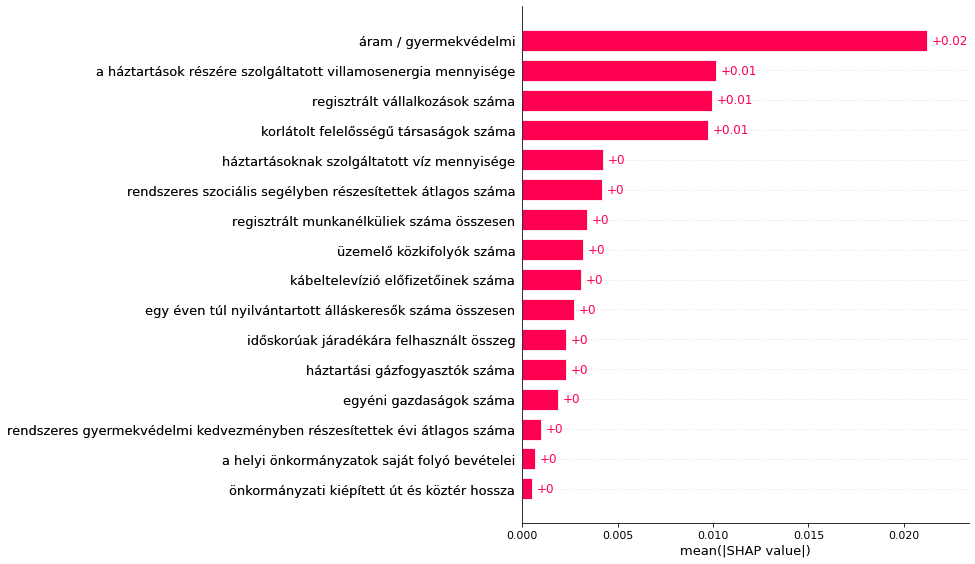

In [ ]:
shap.plots.bar(shap_values_hanyados, max_display=20)

### Gyermekvédelmi / önkormányzat bevétel

In [ ]:
cross_all_hanyados =  cross_all.copy()
cross_all_hanyados['gyermekvédelmi / önkormányzat bevétel'] = cross_all_hanyados['rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma'] / cross_all_hanyados['a helyi önkormányzatok saját folyó bevételei']
cross_all_hanyados.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                        0.090715                        0.262516   
Abaliget                   0.056507                        0.000000   
Abasár                     0.122058                        0.349023   
Abaújalpár                 0.293333                        0.253333   
Abaújkér                   0.124821                        0.170732   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                            0.026744   
Abaliget                                       0.034247   
Abasár                                         0.032708   
Abaújalpár                                     0.013333   
Abaújkér                                       0.018651   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                         0.180573   
Abaliget                                    0.000000   
Abasár                                      0.129637   
Abaújalpár                                  0.000000   
Abaújkér                                    0.000000   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                       0.014549   
Abaliget                                  0.029110   
Abasár                                    0.023135   
Abaújalpár                                0.066667   
Abaújkér                                  0.011478   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                   0.128156   
Abaliget                              0.018836   
Abasár                                0.166733   
Abaújalpár                            0.000000   
Abaújkér                              0.071736   

label       regisztrált munkanélküliek száma összesen  \
geoname                                                 
Aba                                          0.056055   
Abaliget                                     0.099315   
Abasár                                       0.060630   
Abaújalpár                                   0.253333   
Abaújkér                                     0.114778   

label       regisztrált vállalkozások száma  \
geoname                                       
Aba  

In [ ]:
feature_names_hanyados = list(cross_all_hanyados.columns)
feature_names_hanyados.pop(-4)

'személygépkocsik száma'

In [ ]:
X_train_hanyados, X_test_hanyados, y_train_hanyados, y_test_hanyados = train_test_split(cross_all_hanyados[feature_names_hanyados], cross_all_hanyados['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_hanyados = xgb.XGBRegressor(random_state=42)
xgb_model_hanyados.fit(X_train_hanyados, y_train_hanyados)

[12:29:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_hanyados = shap.Explainer(xgb_model_hanyados, X_train_hanyados)
shap_values_hanyados = explainer_hanyados(X_test_hanyados)

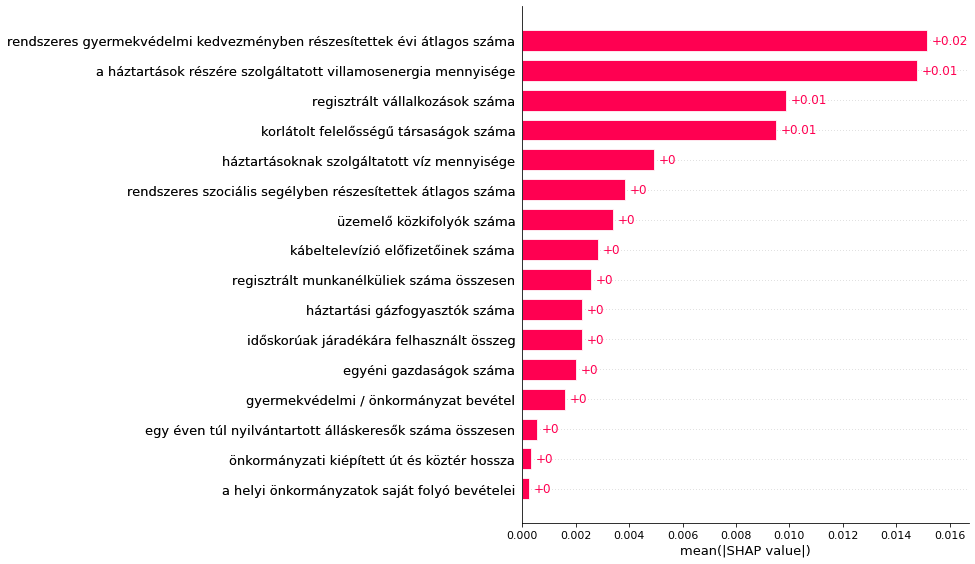

In [ ]:
shap.plots.bar(shap_values_hanyados, max_display=20)

In [ ]:
cross_all_hanyados =  cross_all.copy()
cross_all_hanyados['önkormányzat bevétel / gyermekvédelmi'] = cross_all_hanyados['a helyi önkormányzatok saját folyó bevételei'] / cross_all_hanyados['rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma'] 
cross_all_hanyados.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                        0.090715                        0.262516   
Abaliget                   0.056507                        0.000000   
Abasár                     0.122058                        0.349023   
Abaújalpár                 0.293333                        0.253333   
Abaújkér                   0.124821                        0.170732   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                            0.026744   
Abaliget                                       0.034247   
Abasár                                         0.032708   
Abaújalpár                                     0.013333   
Abaújkér                                       0.018651   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                         0.180573   
Abaliget                                    0.000000   
Abasár                                      0.129637   
Abaújalpár                                  0.000000   
Abaújkér                                    0.000000   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                       0.014549   
Abaliget                                  0.029110   
Abasár                                    0.023135   
Abaújalpár                                0.066667   
Abaújkér                                  0.011478   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                   0.128156   
Abaliget                              0.018836   
Abasár                                0.166733   
Abaújalpár                            0.000000   
Abaújkér                              0.071736   

label       regisztrált munkanélküliek száma összesen  \
geoname                                                 
Aba                                          0.056055   
Abaliget                                     0.099315   
Abasár                                       0.060630   
Abaújalpár                                   0.253333   
Abaújkér                                     0.114778   

label       regisztrált vállalkozások száma  \
geoname                                       
Aba  

In [ ]:
feature_names_hanyados = list(cross_all_hanyados.columns)
feature_names_hanyados.pop(-4)

'személygépkocsik száma'

In [ ]:
X_train_hanyados, X_test_hanyados, y_train_hanyados, y_test_hanyados = train_test_split(cross_all_hanyados[feature_names_hanyados], cross_all_hanyados['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_hanyados = xgb.XGBRegressor(random_state=42)
xgb_model_hanyados.fit(X_train_hanyados, y_train_hanyados)

[12:29:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_hanyados = shap.Explainer(xgb_model_hanyados, X_train_hanyados)
shap_values_hanyados = explainer_hanyados(X_test_hanyados)

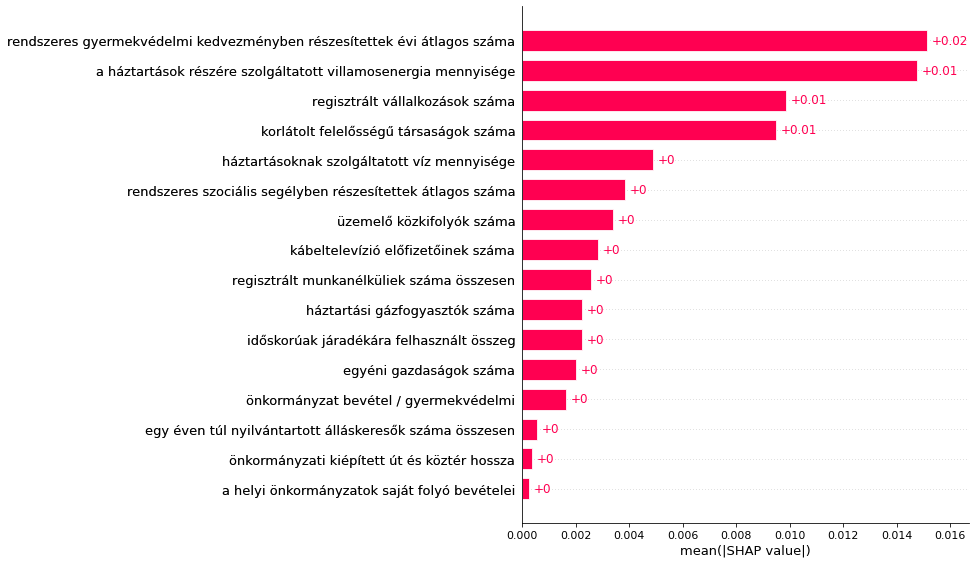

In [ ]:
shap.plots.bar(shap_values_hanyados, max_display=20)

### Önkormányzat bevétel / egy éven túli álláskeresők

In [ ]:
cross_all_hanyados =  cross_all.copy()
cross_all_hanyados['önkormányzat bevétel / egy éven túli álláskeresők'] = cross_all_hanyados['a helyi önkormányzatok saját folyó bevételei'] / cross_all_hanyados['egy éven túl nyilvántartott álláskeresők száma összesen']
cross_all_hanyados.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                        0.090715                        0.262516   
Abaliget                   0.056507                        0.000000   
Abasár                     0.122058                        0.349023   
Abaújalpár                 0.293333                        0.253333   
Abaújkér                   0.124821                        0.170732   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                            0.026744   
Abaliget                                       0.034247   
Abasár                                         0.032708   
Abaújalpár                                     0.013333   
Abaújkér                                       0.018651   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                         0.180573   
Abaliget                                    0.000000   
Abasár                                      0.129637   
Abaújalpár                                  0.000000   
Abaújkér                                    0.000000   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                       0.014549   
Abaliget                                  0.029110   
Abasár                                    0.023135   
Abaújalpár                                0.066667   
Abaújkér                                  0.011478   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                   0.128156   
Abaliget                              0.018836   
Abasár                                0.166733   
Abaújalpár                            0.000000   
Abaújkér                              0.071736   

label       regisztrált munkanélküliek száma összesen  \
geoname                                                 
Aba                                          0.056055   
Abaliget                                     0.099315   
Abasár                                       0.060630   
Abaújalpár                                   0.253333   
Abaújkér                                     0.114778   

label       regisztrált vállalkozások száma  \
geoname                                       
Aba  

In [ ]:
feature_names_hanyados = list(cross_all_hanyados.columns)
feature_names_hanyados.pop(-4)

'személygépkocsik száma'

In [ ]:
X_train_hanyados, X_test_hanyados, y_train_hanyados, y_test_hanyados = train_test_split(cross_all_hanyados[feature_names_hanyados], cross_all_hanyados['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_hanyados = xgb.XGBRegressor(random_state=42)
xgb_model_hanyados.fit(X_train_hanyados, y_train_hanyados)

[12:29:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_hanyados = shap.Explainer(xgb_model_hanyados, X_train_hanyados)
shap_values_hanyados = explainer_hanyados(X_test_hanyados)

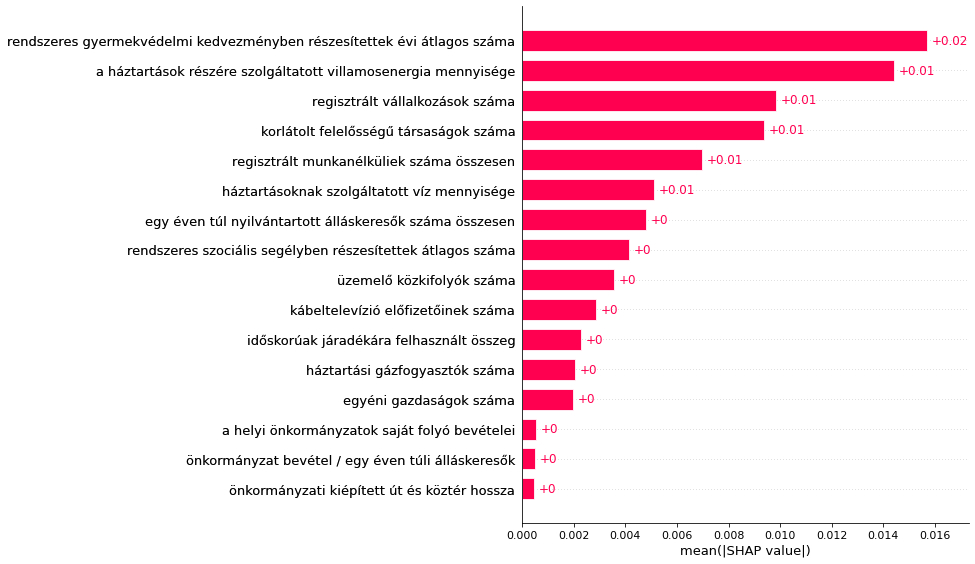

In [ ]:
shap.plots.bar(shap_values_hanyados, max_display=20)

In [ ]:
cross_all_hanyados =  cross_all.copy()
cross_all_hanyados['egy éven túli álláskeresők / önkormányzat bevétel'] = cross_all_hanyados['egy éven túl nyilvántartott álláskeresők száma összesen'] / cross_all_hanyados['a helyi önkormányzatok saját folyó bevételei'] 
cross_all_hanyados.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                        0.090715                        0.262516   
Abaliget                   0.056507                        0.000000   
Abasár                     0.122058                        0.349023   
Abaújalpár                 0.293333                        0.253333   
Abaújkér                   0.124821                        0.170732   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                            0.026744   
Abaliget                                       0.034247   
Abasár                                         0.032708   
Abaújalpár                                     0.013333   
Abaújkér                                       0.018651   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                         0.180573   
Abaliget                                    0.000000   
Abasár                                      0.129637   
Abaújalpár                                  0.000000   
Abaújkér                                    0.000000   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                       0.014549   
Abaliget                                  0.029110   
Abasár                                    0.023135   
Abaújalpár                                0.066667   
Abaújkér                                  0.011478   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                   0.128156   
Abaliget                              0.018836   
Abasár                                0.166733   
Abaújalpár                            0.000000   
Abaújkér                              0.071736   

label       regisztrált munkanélküliek száma összesen  \
geoname                                                 
Aba                                          0.056055   
Abaliget                                     0.099315   
Abasár                                       0.060630   
Abaújalpár                                   0.253333   
Abaújkér                                     0.114778   

label       regisztrált vállalkozások száma  \
geoname                                       
Aba  

In [ ]:
feature_names_hanyados = list(cross_all_hanyados.columns)
feature_names_hanyados.pop(-4)

'személygépkocsik száma'

In [ ]:
X_train_hanyados, X_test_hanyados, y_train_hanyados, y_test_hanyados = train_test_split(cross_all_hanyados[feature_names_hanyados], cross_all_hanyados['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_hanyados = xgb.XGBRegressor(random_state=42)
xgb_model_hanyados.fit(X_train_hanyados, y_train_hanyados)

[12:29:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_hanyados = shap.Explainer(xgb_model_hanyados, X_train_hanyados)
shap_values_hanyados = explainer_hanyados(X_test_hanyados)

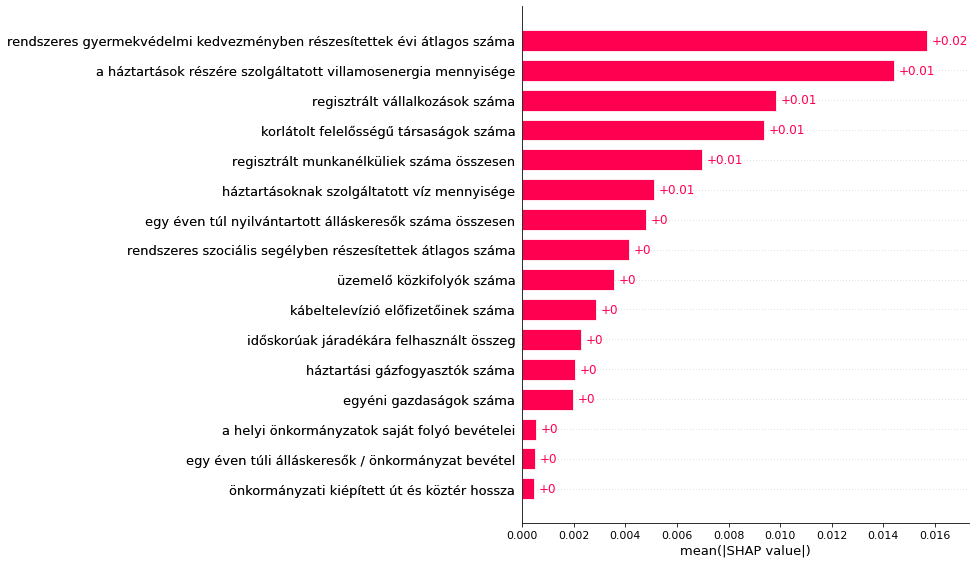

In [ ]:
shap.plots.bar(shap_values_hanyados, max_display=20)

## Oszlopok egymással szorozva

### Gyermekvédelmi/áram

In [ ]:
cross_all_szorzat =  cross_all.copy()
cross_all_szorzat['gyermekvédelmi * áram'] = cross_all_szorzat['rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma'] * cross_all_szorzat['a háztartások részére szolgáltatott villamosenergia mennyisége']
cross_all_szorzat.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                        0.090715                        0.262516   
Abaliget                   0.056507                        0.000000   
Abasár                     0.122058                        0.349023   
Abaújalpár                 0.293333                        0.253333   
Abaújkér                   0.124821                        0.170732   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                            0.026744   
Abaliget                                       0.034247   
Abasár                                         0.032708   
Abaújalpár                                     0.013333   
Abaújkér                                       0.018651   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                         0.180573   
Abaliget                                    0.000000   
Abasár                                      0.129637   
Abaújalpár                                  0.000000   
Abaújkér                                    0.000000   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                       0.014549   
Abaliget                                  0.029110   
Abasár                                    0.023135   
Abaújalpár                                0.066667   
Abaújkér                                  0.011478   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                   0.128156   
Abaliget                              0.018836   
Abasár                                0.166733   
Abaújalpár                            0.000000   
Abaújkér                              0.071736   

label       regisztrált munkanélküliek száma összesen  \
geoname                                                 
Aba                                          0.056055   
Abaliget                                     0.099315   
Abasár                                       0.060630   
Abaújalpár                                   0.253333   
Abaújkér                                     0.114778   

label       regisztrált vállalkozások száma  \
geoname                                       
Aba  

In [ ]:
feature_names_szorzat = list(cross_all_szorzat.columns)
feature_names_szorzat.pop(-4)

'személygépkocsik száma'

In [ ]:
X_train_szorzat, X_test_szorzat, y_train_szorzat, y_test_szorzat = train_test_split(cross_all_szorzat[feature_names_szorzat], cross_all_szorzat['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_szorzat = xgb.XGBRegressor(random_state=42)
xgb_model_szorzat.fit(X_train_szorzat, y_train_szorzat)

[12:29:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_szorzat = shap.Explainer(xgb_model_szorzat, X_train_szorzat)
shap_values_szorzat = explainer_szorzat(X_test_szorzat)

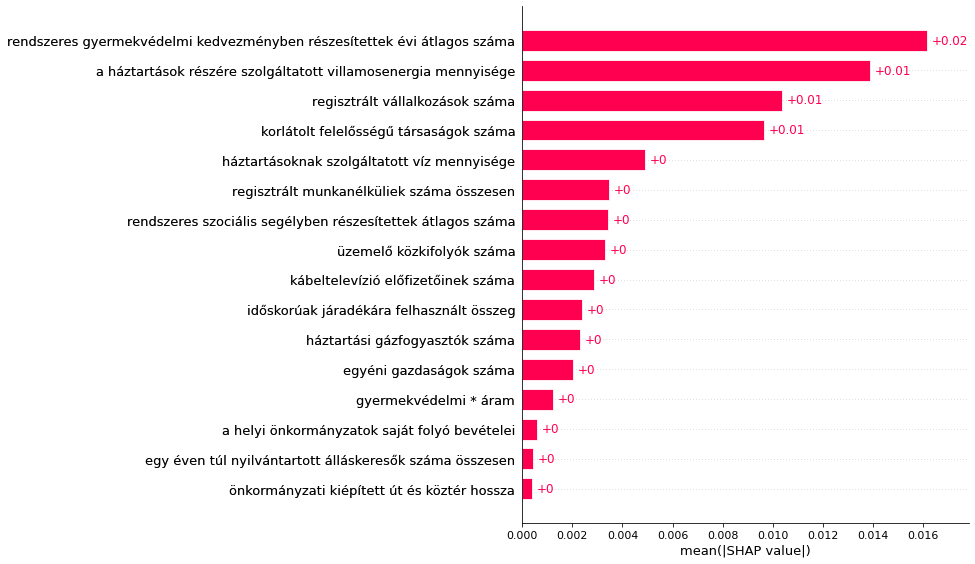

In [ ]:
shap.plots.bar(shap_values_szorzat, max_display=20)

### Gyermekvédelmi / önkormányzat bevétel

In [ ]:
cross_all_szorzat =  cross_all.copy()
cross_all_szorzat['gyermekvédelmi * önkormányzat bevétel'] = cross_all_szorzat['rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma'] * cross_all_szorzat['a helyi önkormányzatok saját folyó bevételei']
cross_all_szorzat.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                        0.090715                        0.262516   
Abaliget                   0.056507                        0.000000   
Abasár                     0.122058                        0.349023   
Abaújalpár                 0.293333                        0.253333   
Abaújkér                   0.124821                        0.170732   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                            0.026744   
Abaliget                                       0.034247   
Abasár                                         0.032708   
Abaújalpár                                     0.013333   
Abaújkér                                       0.018651   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                         0.180573   
Abaliget                                    0.000000   
Abasár                                      0.129637   
Abaújalpár                                  0.000000   
Abaújkér                                    0.000000   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                       0.014549   
Abaliget                                  0.029110   
Abasár                                    0.023135   
Abaújalpár                                0.066667   
Abaújkér                                  0.011478   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                   0.128156   
Abaliget                              0.018836   
Abasár                                0.166733   
Abaújalpár                            0.000000   
Abaújkér                              0.071736   

label       regisztrált munkanélküliek száma összesen  \
geoname                                                 
Aba                                          0.056055   
Abaliget                                     0.099315   
Abasár                                       0.060630   
Abaújalpár                                   0.253333   
Abaújkér                                     0.114778   

label       regisztrált vállalkozások száma  \
geoname                                       
Aba  

In [ ]:
feature_names_szorzat = list(cross_all_szorzat.columns)
feature_names_szorzat.pop(-4)

'személygépkocsik száma'

In [ ]:
X_train_szorzat, X_test_szorzat, y_train_szorzat, y_test_szorzat = train_test_split(cross_all_szorzat[feature_names_szorzat], cross_all_szorzat['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_szorzat = xgb.XGBRegressor(random_state=42)
xgb_model_szorzat.fit(X_train_szorzat, y_train_szorzat)

[12:29:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_szorzat = shap.Explainer(xgb_model_szorzat, X_train_szorzat)
shap_values_szorzat = explainer_szorzat(X_test_szorzat)

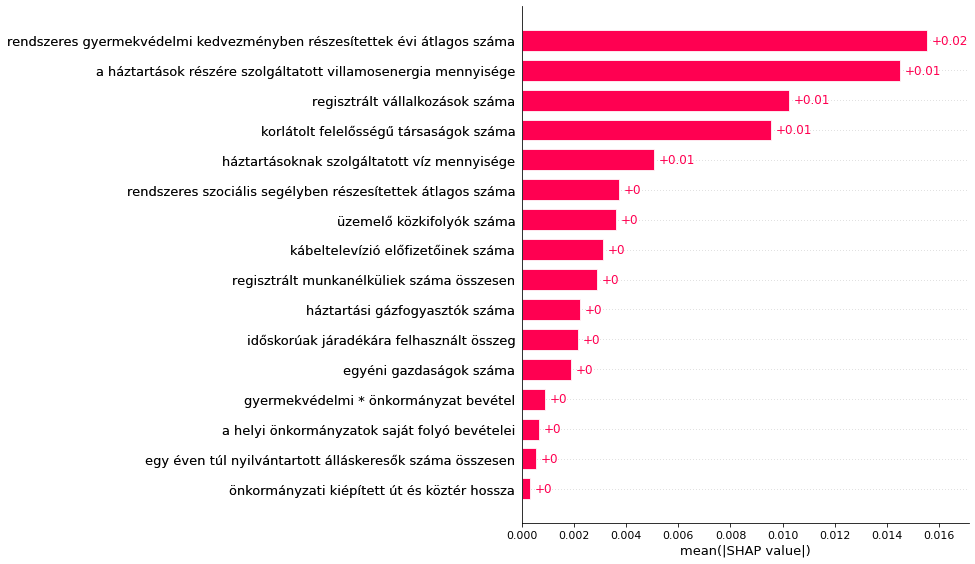

In [ ]:
shap.plots.bar(shap_values_szorzat, max_display=20)

### Önkormányzat bevétel / egy éven túli álláskeresők

In [ ]:
cross_all_szorzat =  cross_all.copy()
cross_all_szorzat['önkormányzat bevétel * egy éven túli álláskeresők'] = cross_all_szorzat['a helyi önkormányzatok saját folyó bevételei'] * cross_all_szorzat['egy éven túl nyilvántartott álláskeresők száma összesen']
cross_all_szorzat.head()

label       a helyi önkormányzatok saját folyó bevételei  \
geoname                                                    
Aba                                            28.725931   
Abaliget                                       24.957192   
Abasár                                         86.654168   
Abaújalpár                                     17.506667   
Abaújkér                                       22.948350   

label       a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                      
Aba                                                  0.926401                
Abaliget                                             1.316781                
Abasár                                               1.375349                
Abaújalpár                                           0.760000                
Abaújkér                                             0.862267                

label       egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                               
Aba                                                  0.009628         
Abaliget                                             0.015411         
Abasár                                               0.018748         
Abaújalpár                                           0.080000         
Abaújkér                                             0.030129         

label       egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                               
Aba                        0.090715                        0.262516   
Abaliget                   0.056507                        0.000000   
Abasár                     0.122058                        0.349023   
Abaújalpár                 0.293333                        0.253333   
Abaújkér                   0.124821                        0.170732   

label       háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                   
Aba                                            0.026744   
Abaliget                                       0.034247   
Abasár                                         0.032708   
Abaújalpár                                     0.013333   
Abaújkér                                       0.018651   

label       időskorúak járadékára felhasznált összeg  \
geoname                                                
Aba                                         0.180573   
Abaliget                                    0.000000   
Abasár                                      0.129637   
Abaújalpár                                  0.000000   
Abaújkér                                    0.000000   

label       korlátolt felelősségű társaságok száma  \
geoname                                              
Aba                                       0.014549   
Abaliget                                  0.029110   
Abasár                                    0.023135   
Abaújalpár                                0.066667   
Abaújkér                                  0.011478   

label       kábeltelevízió előfizetőinek száma  \
geoname                                          
Aba                                   0.128156   
Abaliget                              0.018836   
Abasár                                0.166733   
Abaújalpár                            0.000000   
Abaújkér                              0.071736   

label       regisztrált munkanélküliek száma összesen  \
geoname                                                 
Aba                                          0.056055   
Abaliget                                     0.099315   
Abasár                                       0.060630   
Abaújalpár                                   0.253333   
Abaújkér                                     0.114778   

label       regisztrált vállalkozások száma  \
geoname                                       
Aba  

In [ ]:
feature_names_szorzat = list(cross_all_szorzat.columns)
feature_names_szorzat.pop(-4)

'személygépkocsik száma'

In [ ]:
X_train_szorzat, X_test_szorzat, y_train_szorzat, y_test_szorzat = train_test_split(cross_all_szorzat[feature_names_szorzat], cross_all_szorzat['személygépkocsik száma'], test_size=0.2, random_state=42)

In [ ]:
xgb_model_szorzat = xgb.XGBRegressor(random_state=42)
xgb_model_szorzat.fit(X_train_szorzat, y_train_szorzat)

[12:29:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_szorzat = shap.Explainer(xgb_model_szorzat, X_train_szorzat)
shap_values_szorzat = explainer_szorzat(X_test_szorzat)

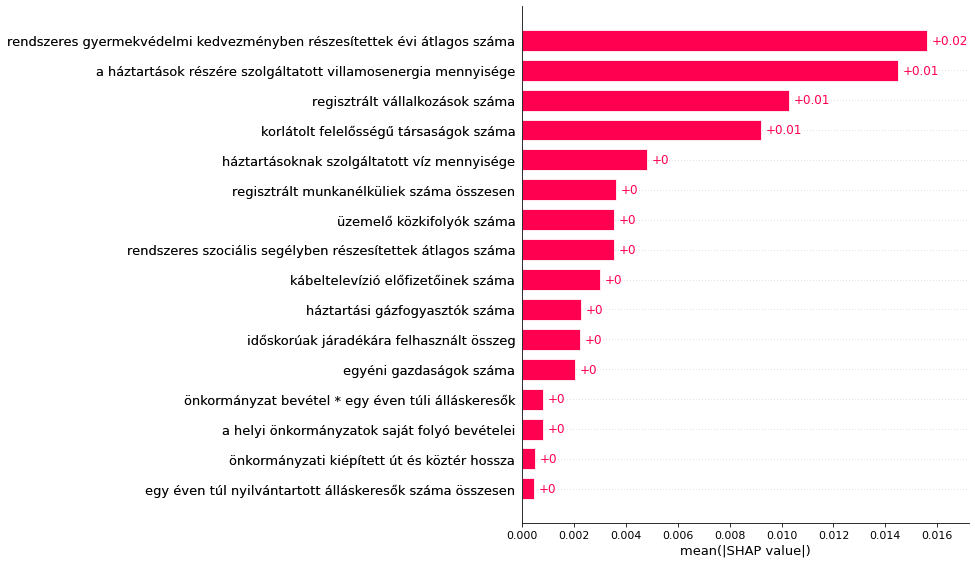

In [ ]:
shap.plots.bar(shap_values_szorzat, max_display=20)

# **4. Shapley**

### Wine dataset

In [ ]:
df_wine = pd.read_csv('/content/winequality-red.csv')

FileNotFoundError: ignored

In [ ]:
df_wine['quality'] = df_wine['quality'].astype(int)
df_wine.head()

In [ ]:
features_wine = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Y_wine = df_wine['quality']
X_wine =  df_wine[features_wine]
X_train_wine, X_test_wine, Y_train_wine, Y_test_wine = train_test_split(X_wine, Y_wine, test_size = 0.2, random_state = 1234)
xgb_model_wine = xgb.XGBRegressor(random_state=42)
xgb_model_wine.fit(X_train_wine, Y_train_wine)

In [ ]:
explainer_wine = shap.Explainer(xgb_model_wine)
shap_values_wine = explainer_wine(X_test_wine)

In [ ]:
shap.plots.bar(shap_values_wine, max_display=10)

In [ ]:
#shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

In [ ]:
X_y_test_wine = X_test_wine.copy()
X_y_test_wine['quality'] = Y_test_wine
X_y_test_wine.head()

In [ ]:
alcohol_less = X_y_test_wine[X_y_test_wine["alcohol"] < 11.4499]
alcohol_more = X_y_test_wine[X_y_test_wine["alcohol"] >= 11.4499]
alcohol_more.head()

In [ ]:
alcohol_less.shape

In [ ]:
Y_cohort = alcohol_less['quality']
X_cohort =  alcohol_less[features_wine]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort, Y_cohort, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBRegressor(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

In [ ]:
explainer_cohort = shap.Explainer(xgb_model_cohort)
shap_values_cohort = explainer_cohort(X_test_cohort)

In [ ]:
shap.plots.bar(shap_values_cohort, max_display=10)

In [ ]:
Y_cohort = alcohol_more['quality']
X_cohort =  alcohol_more[features_wine]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort, Y_cohort, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBRegressor(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

In [ ]:
explainer_cohort = shap.Explainer(xgb_model_cohort)
shap_values_cohort = explainer_cohort(X_test_cohort)

In [ ]:
shap_values_cohort.abs.mean(0).values

In [ ]:
shap.plots.bar(shap_values_cohort, max_display=10)

In [ ]:
m_wine = DecisionTreeRegressor(max_leaf_nodes=2)
m_wine.fit(shap_values_wine.data, shap_values_wine.values)

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(m_wine, 
                   feature_names=features_wine,  
                   filled=True)

### Cohorts

In [ ]:
munkanelkuliseg_less = cross_all[cross_all["regisztrált munkanélküliek száma összesen"] < 0.15]
munkanelkuliseg_more = cross_all[cross_all["regisztrált munkanélküliek száma összesen"] >= 0.15]
munkanelkuliseg_less.head()

label     a helyi önkormányzatok saját folyó bevételei  \
geoname                                                  
Aba                                          28.725931   
Abaliget                                     24.957192   
Abasár                                       86.654168   
Abaújkér                                     22.948350   
Abaújlak                                     12.759124   

label     a háztartások részére szolgáltatott villamosenergia mennyisége  \
geoname                                                                    
Aba                                                0.926401                
Abaliget                                           1.316781                
Abasár                                             1.375349                
Abaújkér                                           0.862267                
Abaújlak                                           0.496350                

label     egy éven túl nyilvántartott álláskeresők száma összesen  \
geoname                                                             
Aba                                                0.009628         
Abaliget                                           0.015411         
Abasár                                             0.018748         
Abaújkér                                           0.030129         
Abaújlak                                           0.014599         

label     egyéni gazdaságok száma  háztartási gázfogyasztók száma  \
geoname                                                             
Aba                      0.090715                        0.262516   
Abaliget                 0.056507                        0.000000   
Abasár                   0.122058                        0.349023   
Abaújkér                 0.124821                        0.170732   
Abaújlak                 0.043796                        0.000000   

label     háztartásoknak szolgáltatott víz mennyisége  \
geoname                                                 
Aba                                          0.026744   
Abaliget                                     0.034247   
Abasár                                       0.032708   
Abaújkér                                     0.018651   
Abaújlak                                     0.007299   

label     időskorúak járadékára felhasznált összeg  \
geoname                                              
Aba                                       0.180573   
Abaliget                                  0.000000   
Abasár                                    0.129637   
Abaújkér                                  0.000000   
Abaújlak                                  0.000000   

label     korlátolt felelősségű társaságok száma  \
geoname                                            
Aba                                     0.014549   
Abaliget                                0.029110   
Abasár                                  0.023135   
Abaújkér                                0.011478   
Abaújlak                                0.021898   

label     kábeltelevízió előfizetőinek száma  \
geoname                                        
Aba                                 0.128156   
Abaliget                            0.018836   
Abasár                              0.166733   
Abaújkér                            0.071736   
Abaújlak                            0.000000   

label     regisztrált munkanélküliek száma összesen  \
geoname                                               
Aba                                        0.056055   
Abaliget                                   0.099315   
Abasár                                     0.060630   
Abaújkér                                   0.114778   
Abaújlak                                   0.058394   

label     regisztrált vállalkozások száma  \
geoname                                     
Aba                              0.105263   
Abaliget                         0.159247   
Abasár                           0.254487   


In [ ]:
feature_names = list(cross_all.columns)
feature_names.pop(-3)

'személygépkocsik száma'

In [ ]:
Y_cohort_less = munkanelkuliseg_less['személygépkocsik száma']
X_cohort_less =  munkanelkuliseg_less[feature_names]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort_less, Y_cohort_less, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBRegressor(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

[12:30:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_cohort_less = shap.Explainer(xgb_model_cohort)
shap_values_cohort_less = explainer_cohort_less(X_test_cohort)

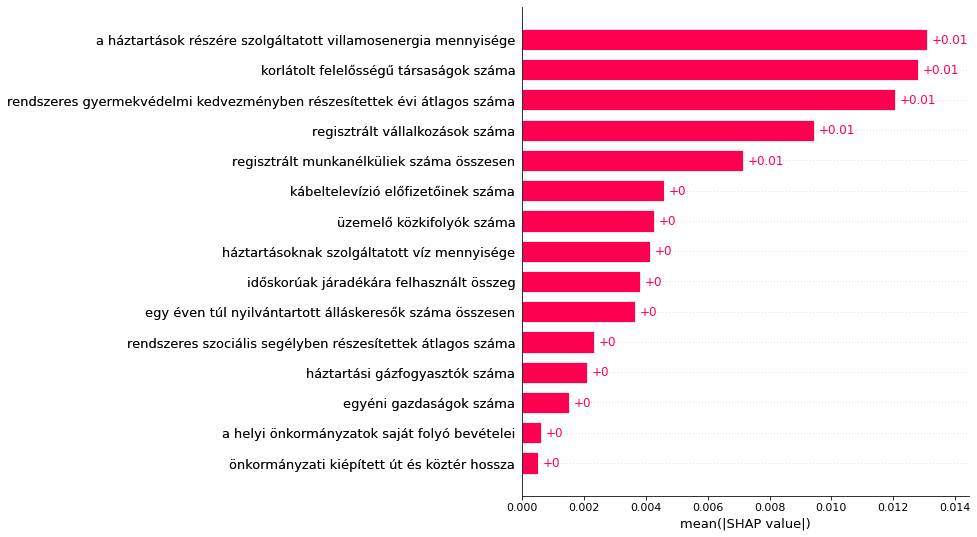

In [ ]:
shap.plots.bar(shap_values_cohort_less, max_display=20)

In [ ]:
Y_cohort_more = munkanelkuliseg_more['személygépkocsik száma']
X_cohort_more =  munkanelkuliseg_more[feature_names]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort_more, Y_cohort_more, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBRegressor(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

[12:30:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=42)

In [ ]:
explainer_cohort_more = shap.Explainer(xgb_model_cohort)
shap_values_cohort_more = explainer_cohort_more(X_test_cohort)

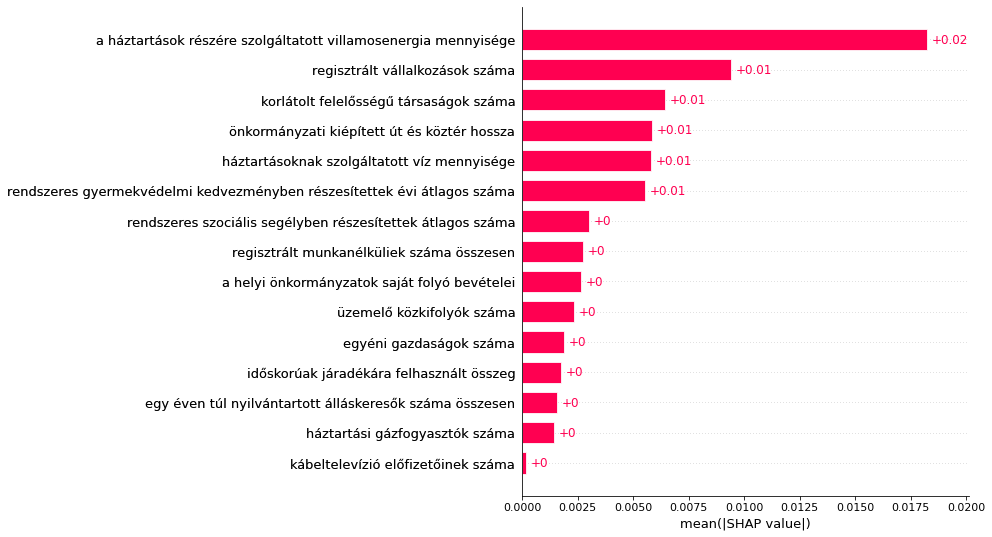

In [ ]:
shap.plots.bar(shap_values_cohort_more, max_display=20)

### Orvosi adaton

In [ ]:
wdbc_feature_names=['ID', 'Diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal dimension_se', 'radius_wr', 'texture_wr', 'perimeter_wr', 'area_wr', 'smoothness_wr', 'compactness_wr', 'concavity_wr', 'concave points_wr', 'symmetry_wr', 'fractal dimension_wr']

In [ ]:
bc_data = pd.read_csv('/content/wdbc.data',names=wdbc_feature_names, index_col=0)
bc_data.head()

Diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
ID                                                                         
842302           M        17.99         10.38          122.80     1001.0   
842517           M        20.57         17.77          132.90     1326.0   
84300903         M        19.69         21.25          130.00     1203.0   
84348301         M        11.42         20.38           77.58      386.1   
84358402         M        20.29         14.34          135.10     1297.0   

          smoothness_mean  compactness_mean  concavity_mean  \
ID                                                            
842302            0.11840           0.27760          0.3001   
842517            0.08474           0.07864          0.0869   
84300903          0.10960           0.15990          0.1974   
84348301          0.14250           0.28390          0.2414   
84358402          0.10030           0.13280          0.1980   

          concave points_mean  symmetry_mean  ...  radius_wr  texture_wr  \
ID                                            ...                          
842302                0.14710         0.2419  ...      25.38       17.33   
842517                0.07017         0.1812  ...      24.99       23.41   
84300903              0.12790         0.2069  ...      23.57       25.53   
84348301              0.10520         0.2597  ...      14.91       26.50   
84358402              0.10430         0.1809  ...      22.54       16.67   

          perimeter_wr  area_wr  smoothness_wr  compactness_wr  concavity_wr  \
ID                                                                             
842302          184.60   2019.0         0.1622          0.6656        0.7119   
842517          158.80   1956.0         0.1238          0.1866        0.2416   
84300903        152.50   1709.0         0.1444          0.4245        0.4504   
84348301         98.87    567.7         0.2098          0.8663        0.6869   
84358402        152.20   1575.0         0.1374          0.2050        0.4000   

          concave points_wr  symmetry_wr  fractal dimension_wr  
ID                                                              
842302               0.2654       0.4601               0.11890  
842517               0.1860       0.2750               0.08902  
84300903             0.2430       0.3613               0.08758  
84348301             0.2575       0.6638               0.17300  
84358402             0.1625       0.2364               0.07678  

[5 rows x 31 columns]

In [ ]:
bc_data_mean = bc_data.iloc[:, :11]

In [ ]:
bc_data_mean.head()

Diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
ID                                                                         
842302           M        17.99         10.38          122.80     1001.0   
842517           M        20.57         17.77          132.90     1326.0   
84300903         M        19.69         21.25          130.00     1203.0   
84348301         M        11.42         20.38           77.58      386.1   
84358402         M        20.29         14.34          135.10     1297.0   

          smoothness_mean  compactness_mean  concavity_mean  \
ID                                                            
842302            0.11840           0.27760          0.3001   
842517            0.08474           0.07864          0.0869   
84300903          0.10960           0.15990          0.1974   
84348301          0.14250           0.28390          0.2414   
84358402          0.10030           0.13280          0.1980   

          concave points_mean  symmetry_mean  fractal dimension_mean  
ID                                                                    
842302                0.14710         0.2419                 0.07871  
842517                0.07017         0.1812                 0.05667  
84300903              0.12790         0.2069                 0.05999  
84348301              0.10520         0.2597                 0.09744  
84358402              0.10430         0.1809                 0.05883

In [ ]:
from xgboost import XGBClassifier

In [ ]:
features_bc = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
            'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal dimension_mean']
Y = bc_data_mean['Diagnosis']
X =  bc_data_mean[features_bc]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1234)
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, Y_train)

XGBClassifier(random_state=42)

In [ ]:
explainer_bc = shap.Explainer(xgb_model, X_train)
shap_values_bc = explainer_bc(X_test)

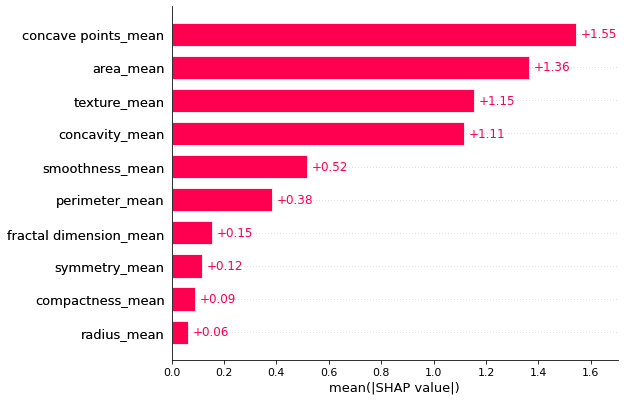

In [ ]:
shap.plots.bar(shap_values_bc, max_display=15)

Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.


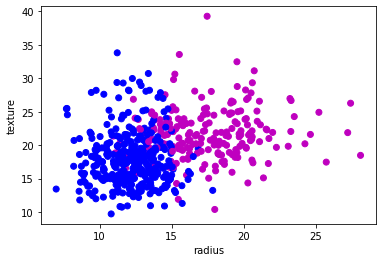

In [ ]:
radius_l = list(bc_data_mean['radius_mean'])
texture_l = list(bc_data_mean['texture_mean'])

plt.scatter(radius_l, texture_l, c=list(bc_data_mean['Diagnosis']))

plt.xlabel('radius')
plt.ylabel('texture')
plt.show()

#### Radius

In [ ]:
radius_less = bc_data_mean[bc_data_mean["radius_mean"] < 15]
radius_more = bc_data_mean[bc_data_mean["radius_mean"] >= 15]
radius_less.head()

Diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
ID                                                                         
84348301         M        11.42         20.38           77.58      386.1   
843786           M        12.45         15.70           82.57      477.1   
84458202         M        13.71         20.83           90.20      577.9   
844981           M        13.00         21.82           87.50      519.8   
84501001         M        12.46         24.04           83.97      475.9   

          smoothness_mean  compactness_mean  concavity_mean  \
ID                                                            
84348301           0.1425            0.2839         0.24140   
843786             0.1278            0.1700         0.15780   
84458202           0.1189            0.1645         0.09366   
844981             0.1273            0.1932         0.18590   
84501001           0.1186            0.2396         0.22730   

          concave points_mean  symmetry_mean  fractal dimension_mean  
ID                                                                    
84348301              0.10520         0.2597                 0.09744  
843786                0.08089         0.2087                 0.07613  
84458202              0.05985         0.2196                 0.07451  
844981                0.09353         0.2350                 0.07389  
84501001              0.08543         0.2030                 0.08243

In [ ]:
Y_cohort_less = radius_less['Diagnosis']
X_cohort_less =  radius_less[features_bc]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort_less, Y_cohort_less, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBClassifier(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

XGBClassifier(random_state=42)

In [ ]:
explainer_cohort_less = shap.Explainer(xgb_model_cohort)
shap_values_cohort_less = explainer_cohort_less(X_test_cohort)

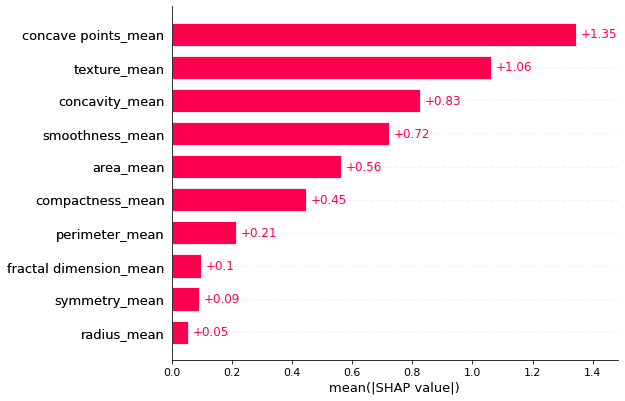

In [ ]:
shap.plots.bar(shap_values_cohort_less, max_display=20)

In [ ]:
Y_cohort_more = radius_more['Diagnosis']
X_cohort_more =  radius_more[features_bc]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort_more, Y_cohort_more, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBClassifier(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

XGBClassifier(random_state=42)

In [ ]:
explainer_cohort_more = shap.Explainer(xgb_model_cohort)
shap_values_cohort_more = explainer_cohort_more(X_test_cohort)

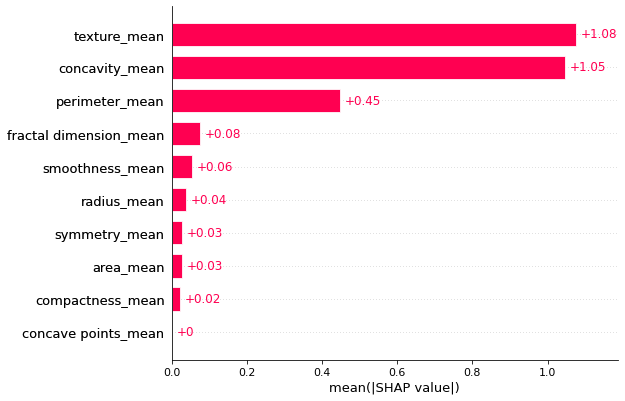

In [ ]:
shap.plots.bar(shap_values_cohort_more, max_display=20)

#### Texture

In [ ]:
texture_less = bc_data_mean[bc_data_mean["texture_mean"] < 15]
texture_more = bc_data_mean[bc_data_mean["texture_mean"] >= 15]
texture_less.head()

Diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
ID                                                                         
842302           M       17.990         10.38          122.80     1001.0   
84358402         M       20.290         14.34          135.10     1297.0   
8510426          B       13.540         14.36           87.46      566.3   
8510824          B        9.504         12.44           60.34      273.9   
8511133          M       15.340         14.26          102.50      704.4   

          smoothness_mean  compactness_mean  concavity_mean  \
ID                                                            
842302            0.11840           0.27760         0.30010   
84358402          0.10030           0.13280         0.19800   
8510426           0.09779           0.08129         0.06664   
8510824           0.10240           0.06492         0.02956   
8511133           0.10730           0.21350         0.20770   

          concave points_mean  symmetry_mean  fractal dimension_mean  
ID                                                                    
842302                0.14710         0.2419                 0.07871  
84358402              0.10430         0.1809                 0.05883  
8510426               0.04781         0.1885                 0.05766  
8510824               0.02076         0.1815                 0.06905  
8511133               0.09756         0.2521                 0.07032

In [ ]:
Y_cohort_more = texture_more['Diagnosis']
X_cohort_more =  texture_more[features_bc]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort_more, Y_cohort_more, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBClassifier(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

XGBClassifier(random_state=42)

In [ ]:
explainer_cohort_more = shap.Explainer(xgb_model_cohort)
shap_values_cohort_more = explainer_cohort_more(X_test_cohort)

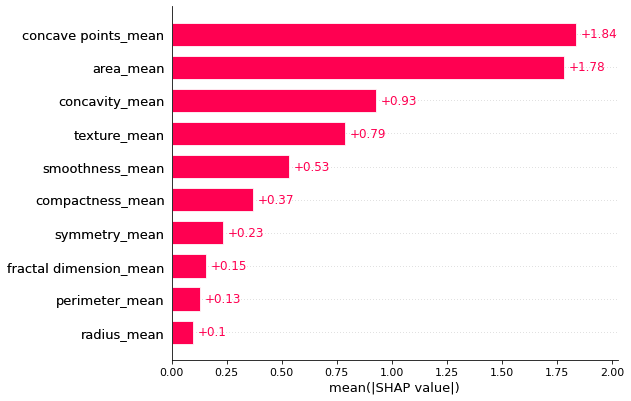

In [ ]:
shap.plots.bar(shap_values_cohort_more, max_display=20)

In [ ]:
Y_cohort_less = texture_less['Diagnosis']
X_cohort_less =  texture_less[features_bc]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort_less, Y_cohort_less, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBClassifier(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

XGBClassifier(random_state=42)

In [ ]:
explainer_cohort_less = shap.Explainer(xgb_model_cohort)
shap_values_cohort_less = explainer_cohort_less(X_test_cohort)

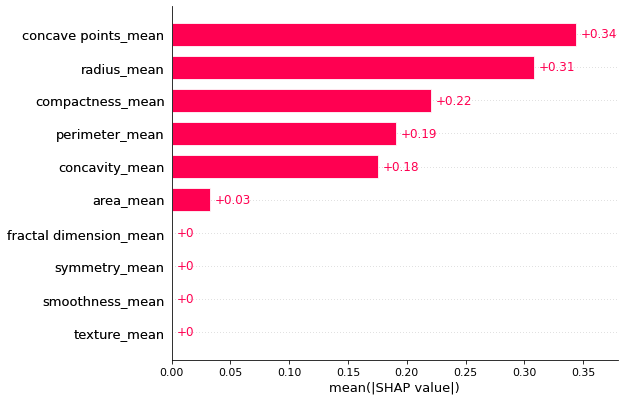

In [ ]:
shap.plots.bar(shap_values_cohort_less, max_display=20)

#### Döntési fa

In [ ]:
m_bc = DecisionTreeRegressor(max_leaf_nodes=2)
m_bc.fit(shap_values_bc.data, shap_values_bc.values)

DecisionTreeRegressor(max_leaf_nodes=2)

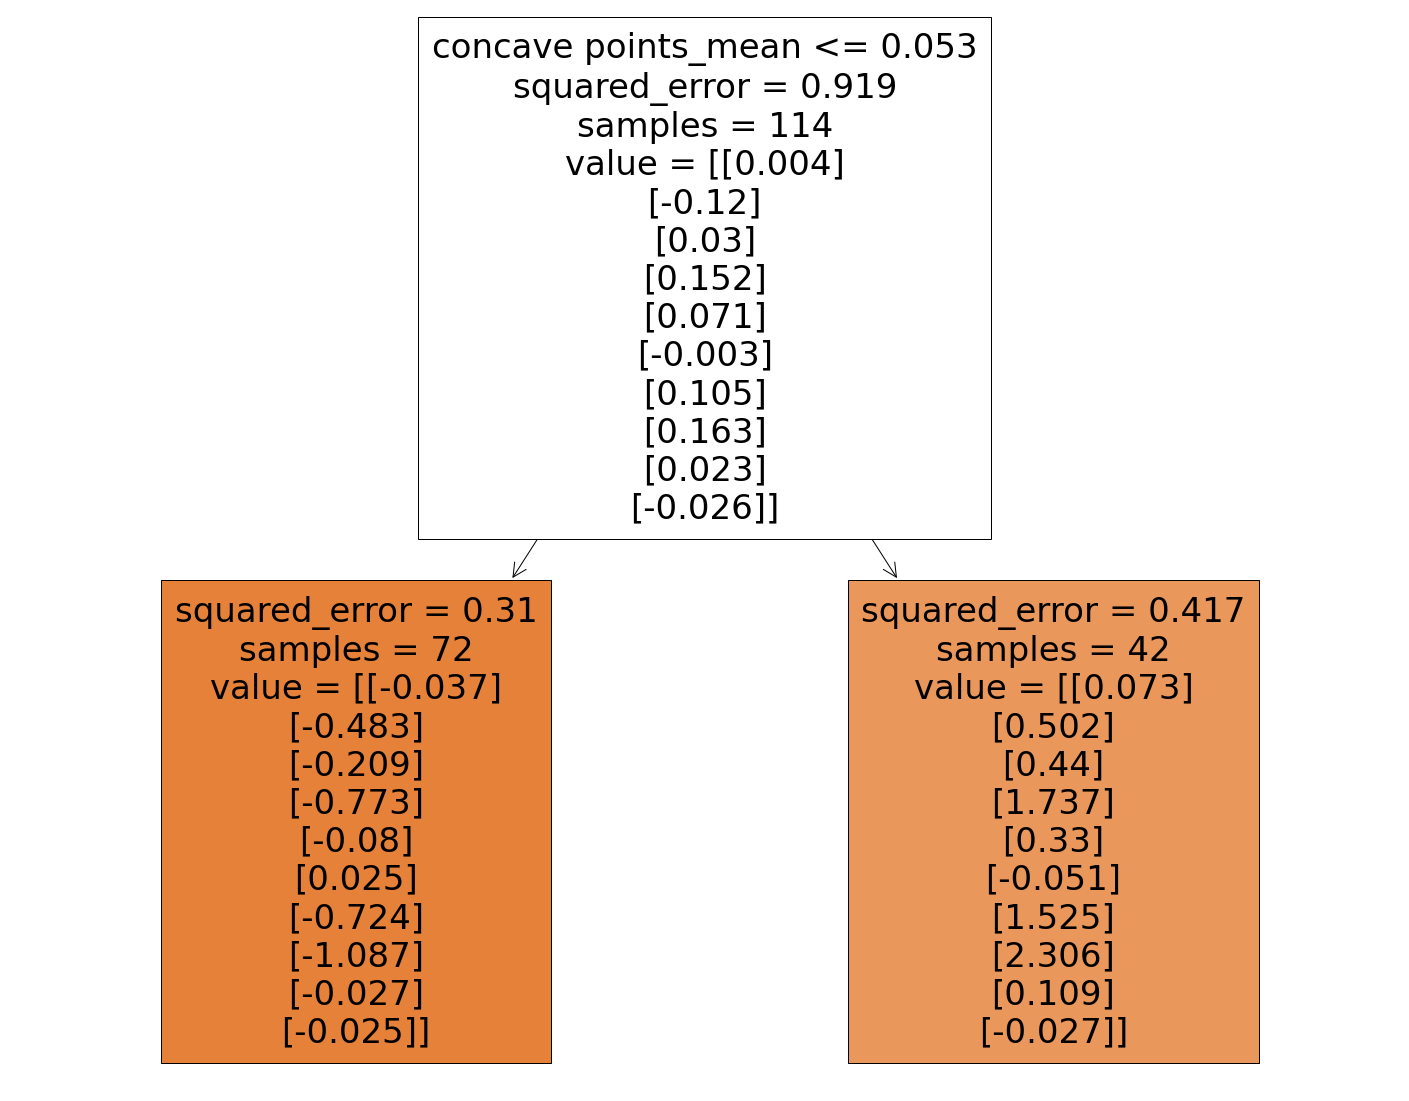

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(m_bc, 
                   feature_names=features_bc,  
                   filled=True)

In [ ]:
concave_points_less = bc_data_mean[bc_data_mean["concave points_mean"] < 0.053]
concave_points_more = bc_data_mean[bc_data_mean["concave points_mean"] >= 0.053]
concave_points_less.head()

Diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
ID                                                                        
845636          M       16.020         23.24          102.70      797.8   
848406          M       14.680         20.13           94.74      684.5   
8510426         B       13.540         14.36           87.46      566.3   
8510653         B       13.080         15.71           85.63      520.0   
8510824         B        9.504         12.44           60.34      273.9   

         smoothness_mean  compactness_mean  concavity_mean  \
ID                                                           
845636           0.08206           0.06669         0.03299   
848406           0.09867           0.07200         0.07395   
8510426          0.09779           0.08129         0.06664   
8510653          0.10750           0.12700         0.04568   
8510824          0.10240           0.06492         0.02956   

         concave points_mean  symmetry_mean  fractal dimension_mean  
ID                                                                   
845636               0.03323         0.1528                 0.05697  
848406               0.05259         0.1586                 0.05922  
8510426              0.04781         0.1885                 0.05766  
8510653              0.03110         0.1967                 0.06811  
8510824              0.02076         0.1815                 0.06905

In [ ]:
Y_cohort_more = concave_points_more['Diagnosis']
X_cohort_more =  concave_points_more[features_bc]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort_more, Y_cohort_more, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBClassifier(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

XGBClassifier(random_state=42)

In [ ]:
explainer_cohort_more = shap.Explainer(xgb_model_cohort)
shap_values_cohort_more = explainer_cohort_more(X_test_cohort)

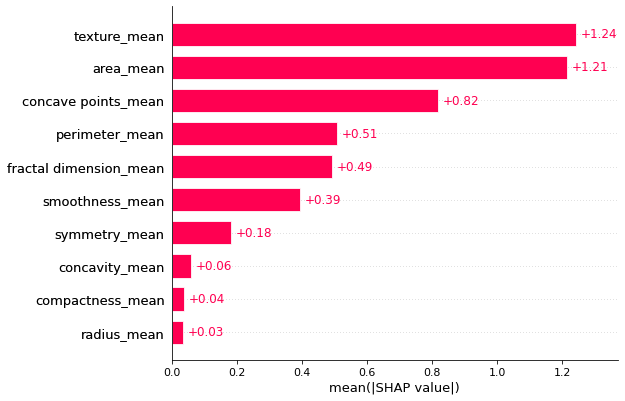

In [ ]:
shap.plots.bar(shap_values_cohort_more, max_display=20)

In [ ]:
Y_cohort_less = concave_points_less['Diagnosis']
X_cohort_less =  concave_points_less[features_bc]

In [ ]:
X_train_cohort, X_test_cohort, Y_train_cohort, Y_test_cohort = train_test_split(X_cohort_less, Y_cohort_less, test_size = 0.2, random_state = 1234)
xgb_model_cohort = xgb.XGBClassifier(random_state=42)
xgb_model_cohort.fit(X_train_cohort, Y_train_cohort)

XGBClassifier(random_state=42)

In [ ]:
explainer_cohort_less = shap.Explainer(xgb_model_cohort)
shap_values_cohort_less = explainer_cohort_less(X_test_cohort)

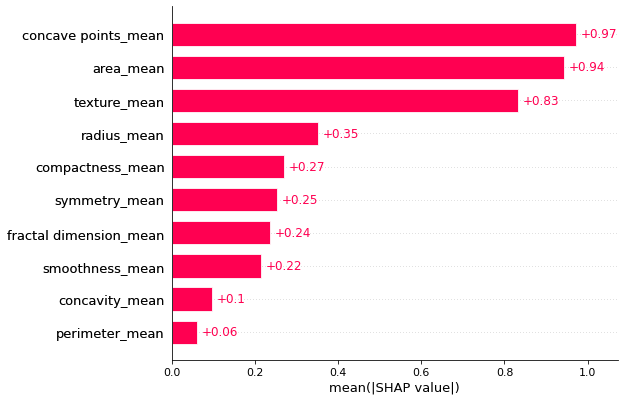

In [ ]:
shap.plots.bar(shap_values_cohort_less, max_display=20)

# **5. Copent**

In [ ]:
!pip install copent

In [ ]:
import copent

In [ ]:
from numpy.random import multivariate_normal as mnorm

rho = 0.6
mean1 = [0,0]
cov1 = [ [1,rho],[rho,1] ]
x = mnorm(mean1,cov1,200) # bivariate gaussian 
ce1 = copent.copent(x) # estimated copula entropy

In [ ]:
ce1

In [ ]:
from copent import transent
from pandas import read_csv
import numpy as np
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv"
prsa2010 = read_csv(url)
# index: 5(PM2.5),6(Dew Point),7(Temperature),8(Pressure),10(Cumulative Wind Speed)
data = prsa2010.iloc[2200:2700,[5,8]].values
te = np.zeros(24)
for lag in range(1,25):
	te[lag-1] = transent(data[:,0],data[:,1],lag)
	str = "TE from pressure to PM2.5 at %d hours lag : %f" %(lag,te[lag-1])
	print(str)

Párok:

In [ ]:
%%time
ce_1 = copent.copent(cross_all[['üzemelő közkifolyók száma', 'személygépkocsik száma']]) # alacsony shapley értéke volt
print(ce_1)

In [ ]:
%%time
ce_2 = copent.copent(cross_all[['a háztartások részére szolgáltatott villamosenergia mennyisége', 'személygépkocsik száma']]) # magas shapley értéke volt
print(ce_2)

Hármasok:

In [ ]:
%%time
ce_3 = copent.copent(cross_all[['a háztartások részére szolgáltatott villamosenergia mennyisége', 'háztartásoknak szolgáltatott víz mennyisége', 'személygépkocsik száma']])
print(ce_3) # mindkettő magas shapley értékű

In [ ]:
%%time
ce_4 = copent.copent(cross_all[['üzemelő közkifolyók száma', 'időskorúak járadékára felhasznált összeg', 'személygépkocsik száma']])
print(ce_4) # mindkettő alacsony shapley értékű

In [ ]:
%%time
ce_5 = copent.copent(cross_all[['üzemelő közkifolyók száma', 'a háztartások részére szolgáltatott villamosenergia mennyisége', 'személygépkocsik száma']])
print(ce_5) # egyik magas, másik alacsony shapley értékű

Összes pár:

Megvannak txt-ben.

In [ ]:
for i in list(cross_all[feature_names].columns):
  print(i + ' és a személygépkocsiszám közti Copula Entropy: ' + str(copent.copent(cross_all[[i, 'személygépkocsik száma']])))

In [ ]:
cross_all[feature_names].columns

Összes hármas:

In [ ]:
for i in list(itertools.combinations(list(cross_all[feature_names].columns), 2)):
  print(i[0] + ', ' + str(i[1]) + ' és a személygépkocsiszám közti Copula Entropy: ' + str(copent.copent(cross_all[[i[0], i[1], 'személygépkocsik száma']])))

In [ ]:
paros_str = 'a helyi önkormányzatok saját folyó bevételei és a személygépkocsiszám közti Copula Entropy: 0.9331458581494543 a háztartások részére szolgáltatott villamosenergia mennyisége és a személygépkocsiszám közti Copula Entropy: 1.8199355781762572 egy éven túl nyilvántartott álláskeresők száma összesen és a személygépkocsiszám közti Copula Entropy: 0.343735586432766 egyéni gazdaságok száma és a személygépkocsiszám közti Copula Entropy: 0.5660372538542884 háztartási gázfogyasztók száma és a személygépkocsiszám közti Copula Entropy: 1.2200976536767056 háztartásoknak szolgáltatott víz mennyisége és a személygépkocsiszám közti Copula Entropy: 1.6253493896882665 időskorúak járadékára felhasznált összeg és a személygépkocsiszám közti Copula Entropy: 0.17363904952351294 korlátolt felelősségű társaságok száma és a személygépkocsiszám közti Copula Entropy: 0.9534325966862793 kábeltelevízió előfizetőinek száma és a személygépkocsiszám közti Copula Entropy: 0.7781666304759272 regisztrált munkanélküliek száma összesen és a személygépkocsiszám közti Copula Entropy: 0.5825990342385117 regisztrált vállalkozások száma és a személygépkocsiszám közti Copula Entropy: 1.1444929834352608 rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma és a személygépkocsiszám közti Copula Entropy: 0.3599323906394867 rendszeres szociális segélyben részesítettek átlagos száma (rendelkezésre állási támogatásban részesülők adatai nélkül)  és a személygépkocsiszám közti Copula Entropy: 0.2648045561095085 önkormányzati kiépített út és köztér hossza és a személygépkocsiszám közti Copula Entropy: 0.6795675204695684 üzemelő közkifolyók száma és a személygépkocsiszám közti Copula Entropy: 0.10657563925845004'
paros_CE = []
for i in  paros_str.split():
  if i[0].isdigit():
    paros_CE.append(i)
print(paros_CE)

In [ ]:
harmas_str = 'a helyi önkormányzatok saját folyó bevételei, a háztartások részére szolgáltatott villamosenergia mennyisége és a személygépkocsiszám közti Copula Entropy: 2.808123801719465 a helyi önkormányzatok saját folyó bevételei, egy éven túl nyilvántartott álláskeresők száma összesen és a személygépkocsiszám közti Copula Entropy: 1.3060020643106176 a helyi önkormányzatok saját folyó bevételei, egyéni gazdaságok száma és a személygépkocsiszám közti Copula Entropy: 1.5197581450871303 a helyi önkormányzatok saját folyó bevételei, háztartási gázfogyasztók száma és a személygépkocsiszám közti Copula Entropy: 2.3380597782396757 a helyi önkormányzatok saját folyó bevételei, háztartásoknak szolgáltatott víz mennyisége és a személygépkocsiszám közti Copula Entropy: 2.6707016657008014 a helyi önkormányzatok saját folyó bevételei, időskorúak járadékára felhasznált összeg és a személygépkocsiszám közti Copula Entropy: 2.6701186162984962 a helyi önkormányzatok saját folyó bevételei, korlátolt felelősségű társaságok száma és a személygépkocsiszám közti Copula Entropy: 2.016320443877139 a helyi önkormányzatok saját folyó bevételei, kábeltelevízió előfizetőinek száma és a személygépkocsiszám közti Copula Entropy: 2.2846501564781088 a helyi önkormányzatok saját folyó bevételei, regisztrált munkanélküliek száma összesen és a személygépkocsiszám közti Copula Entropy: 1.543904823402408 a helyi önkormányzatok saját folyó bevételei, regisztrált vállalkozások száma és a személygépkocsiszám közti Copula Entropy: 2.1612219026915556 a helyi önkormányzatok saját folyó bevételei, rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma és a személygépkocsiszám közti Copula Entropy: 1.3673309894866508 a helyi önkormányzatok saját folyó bevételei, rendszeres szociális segélyben részesítettek átlagos száma (rendelkezésre állási támogatásban részesülők adatai nélkül)  és a személygépkocsiszám közti Copula Entropy: 1.757668531780431 a helyi önkormányzatok saját folyó bevételei, önkormányzati kiépített út és köztér hossza és a személygépkocsiszám közti Copula Entropy: 2.0035988174851598 a helyi önkormányzatok saját folyó bevételei, üzemelő közkifolyók száma és a személygépkocsiszám közti Copula Entropy: 1.4552110910799128 a háztartások részére szolgáltatott villamosenergia mennyisége, egy éven túl nyilvántartott álláskeresők száma összesen és a személygépkocsiszám közti Copula Entropy: 2.2382885238984036 a háztartások részére szolgáltatott villamosenergia mennyisége, egyéni gazdaságok száma és a személygépkocsiszám közti Copula Entropy: 2.4456760024050412 a háztartások részére szolgáltatott villamosenergia mennyisége, háztartási gázfogyasztók száma és a személygépkocsiszám közti Copula Entropy: 3.3288053448450183 a háztartások részére szolgáltatott villamosenergia mennyisége, háztartásoknak szolgáltatott víz mennyisége és a személygépkocsiszám közti Copula Entropy: 3.7453784125281873 a háztartások részére szolgáltatott villamosenergia mennyisége, időskorúak járadékára felhasznált összeg és a személygépkocsiszám közti Copula Entropy: 3.8222279944788555 a háztartások részére szolgáltatott villamosenergia mennyisége, korlátolt felelősségű társaságok száma és a személygépkocsiszám közti Copula Entropy: 3.080004357630558 a háztartások részére szolgáltatott villamosenergia mennyisége, kábeltelevízió előfizetőinek száma és a személygépkocsiszám közti Copula Entropy: 3.30618039413405 a háztartások részére szolgáltatott villamosenergia mennyisége, regisztrált munkanélküliek száma összesen és a személygépkocsiszám közti Copula Entropy: 2.531867228226038 a háztartások részére szolgáltatott villamosenergia mennyisége, regisztrált vállalkozások száma és a személygépkocsiszám közti Copula Entropy: 3.086582200178916 a háztartások részére szolgáltatott villamosenergia mennyisége, rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma és a személygépkocsiszám közti Copula Entropy: 2.317637930530549 a háztartások részére szolgáltatott villamosenergia mennyisége, rendszeres szociális segélyben részesítettek átlagos száma (rendelkezésre állási támogatásban részesülők adatai nélkül)  és a személygépkocsiszám közti Copula Entropy: 3.0524734313360957 a háztartások részére szolgáltatott villamosenergia mennyisége, önkormányzati kiépített út és köztér hossza és a személygépkocsiszám közti Copula Entropy: 3.1478198508757496 a háztartások részére szolgáltatott villamosenergia mennyisége, üzemelő közkifolyók száma és a személygépkocsiszám közti Copula Entropy: 2.6967792643428465 egy éven túl nyilvántartott álláskeresők száma összesen, egyéni gazdaságok száma és a személygépkocsiszám közti Copula Entropy: 1.0359752677693495 egy éven túl nyilvántartott álláskeresők száma összesen, háztartási gázfogyasztók száma és a személygépkocsiszám közti Copula Entropy: 1.7707237268237188 egy éven túl nyilvántartott álláskeresők száma összesen, háztartásoknak szolgáltatott víz mennyisége és a személygépkocsiszám közti Copula Entropy: 2.0712226172307107 egy éven túl nyilvántartott álláskeresők száma összesen, időskorúak járadékára felhasznált összeg és a személygépkocsiszám közti Copula Entropy: 0.5887976101130112 egy éven túl nyilvántartott álláskeresők száma összesen, korlátolt felelősségű társaságok száma és a személygépkocsiszám közti Copula Entropy: 1.4359881367334628 egy éven túl nyilvántartott álláskeresők száma összesen, kábeltelevízió előfizetőinek száma és a személygépkocsiszám közti Copula Entropy: 1.173135851686351 egy éven túl nyilvántartott álláskeresők száma összesen, regisztrált munkanélküliek száma összesen és a személygépkocsiszám közti Copula Entropy: 1.8574670569187992 egy éven túl nyilvántartott álláskeresők száma összesen, regisztrált vállalkozások száma és a személygépkocsiszám közti Copula Entropy: 1.5643320890077073 egy éven túl nyilvántartott álláskeresők száma összesen, rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma és a személygépkocsiszám közti Copula Entropy: 1.2523417410581805 egy éven túl nyilvántartott álláskeresők száma összesen, rendszeres szociális segélyben részesítettek átlagos száma (rendelkezésre állási támogatásban részesülők adatai nélkül)  és a személygépkocsiszám közti Copula Entropy: 0.9753172185611794 egy éven túl nyilvántartott álláskeresők száma összesen, önkormányzati kiépített út és köztér hossza és a személygépkocsiszám közti Copula Entropy: 1.0763748542218616 egy éven túl nyilvántartott álláskeresők száma összesen, üzemelő közkifolyók száma és a személygépkocsiszám közti Copula Entropy: 0.8641276019607878 egyéni gazdaságok száma, háztartási gázfogyasztók száma és a személygépkocsiszám közti Copula Entropy: 1.9339808206710538 egyéni gazdaságok száma, háztartásoknak szolgáltatott víz mennyisége és a személygépkocsiszám közti Copula Entropy: 2.2588852811767604 egyéni gazdaságok száma, időskorúak járadékára felhasznált összeg és a személygépkocsiszám közti Copula Entropy: 2.2877272118935226 egyéni gazdaságok száma, korlátolt felelősségű társaságok száma és a személygépkocsiszám közti Copula Entropy: 1.6404012341856484 egyéni gazdaságok száma, kábeltelevízió előfizetőinek száma és a személygépkocsiszám közti Copula Entropy: 1.8345839008149083 egyéni gazdaságok száma, regisztrált munkanélküliek száma összesen és a személygépkocsiszám közti Copula Entropy: 1.2979623453050815 egyéni gazdaságok száma, regisztrált vállalkozások száma és a személygépkocsiszám közti Copula Entropy: 1.8847015755156198 egyéni gazdaságok száma, rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma és a személygépkocsiszám közti Copula Entropy: 1.0660422371521951 egyéni gazdaságok száma, rendszeres szociális segélyben részesítettek átlagos száma (rendelkezésre állási támogatásban részesülők adatai nélkül)  és a személygépkocsiszám közti Copula Entropy: 1.3642424788435745 egyéni gazdaságok száma, önkormányzati kiépített út és köztér hossza és a személygépkocsiszám közti Copula Entropy: 1.5502949249502462 egyéni gazdaságok száma, üzemelő közkifolyók száma és a személygépkocsiszám közti Copula Entropy: 1.0568508633178206 háztartási gázfogyasztók száma, háztartásoknak szolgáltatott víz mennyisége és a személygépkocsiszám közti Copula Entropy: 3.039838160663364 háztartási gázfogyasztók száma, időskorúak járadékára felhasznált összeg és a személygépkocsiszám közti Copula Entropy: 1.4191398950760137 háztartási gázfogyasztók száma, korlátolt felelősségű társaságok száma és a személygépkocsiszám közti Copula Entropy: 2.518777429227929 háztartási gázfogyasztók száma, kábeltelevízió előfizetőinek száma és a személygépkocsiszám közti Copula Entropy: 2.088412802449356 háztartási gázfogyasztók száma, regisztrált munkanélküliek száma összesen és a személygépkocsiszám közti Copula Entropy: 2.0315520663997875 háztartási gázfogyasztók száma, regisztrált vállalkozások száma és a személygépkocsiszám közti Copula Entropy: 2.6082471570499246 háztartási gázfogyasztók száma, rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma és a személygépkocsiszám közti Copula Entropy: 1.808275061890277 háztartási gázfogyasztók száma, rendszeres szociális segélyben részesítettek átlagos száma (rendelkezésre állási támogatásban részesülők adatai nélkül)  és a személygépkocsiszám közti Copula Entropy: 1.5494958304825905 háztartási gázfogyasztók száma, önkormányzati kiépített út és köztér hossza és a személygépkocsiszám közti Copula Entropy: 2.0576226692476434 háztartási gázfogyasztók száma, üzemelő közkifolyók száma és a személygépkocsiszám közti Copula Entropy: 1.4294655789607686 háztartásoknak szolgáltatott víz mennyisége, időskorúak járadékára felhasznált összeg és a személygépkocsiszám közti Copula Entropy: 1.8331859072295247 háztartásoknak szolgáltatott víz mennyisége, korlátolt felelősségű társaságok száma és a személygépkocsiszám közti Copula Entropy: 2.658032479034733 háztartásoknak szolgáltatott víz mennyisége, kábeltelevízió előfizetőinek száma és a személygépkocsiszám közti Copula Entropy: 2.5122789642272023 háztartásoknak szolgáltatott víz mennyisége, regisztrált munkanélküliek száma összesen és a személygépkocsiszám közti Copula Entropy: 2.3025015801717084 háztartásoknak szolgáltatott víz mennyisége, regisztrált vállalkozások száma és a személygépkocsiszám közti Copula Entropy: 2.976457897489854 háztartásoknak szolgáltatott víz mennyisége, rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma és a személygépkocsiszám közti Copula Entropy: 2.1239045386316677 háztartásoknak szolgáltatott víz mennyisége, rendszeres szociális segélyben részesítettek átlagos száma (rendelkezésre állási támogatásban részesülők adatai nélkül)  és a személygépkocsiszám közti Copula Entropy: 1.9355641475403909 háztartásoknak szolgáltatott víz mennyisége, önkormányzati kiépített út és köztér hossza és a személygépkocsiszám közti Copula Entropy: 2.437042807294117 háztartásoknak szolgáltatott víz mennyisége, üzemelő közkifolyók száma és a személygépkocsiszám közti Copula Entropy: 1.8236774564039768 időskorúak járadékára felhasznált összeg, korlátolt felelősségű társaságok száma és a személygépkocsiszám közti Copula Entropy: 1.1422471440503594 időskorúak járadékára felhasznált összeg, kábeltelevízió előfizetőinek száma és a személygépkocsiszám közti Copula Entropy: 0.9611063523892307 időskorúak járadékára felhasznált összeg, regisztrált munkanélküliek száma összesen és a személygépkocsiszám közti Copula Entropy: 2.2958748691298014 időskorúak járadékára felhasznált összeg, regisztrált vállalkozások száma és a személygépkocsiszám közti Copula Entropy: 1.3736096962284252 időskorúak járadékára felhasznált összeg, rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma és a személygépkocsiszám közti Copula Entropy: 2.057524486627842 időskorúak járadékára felhasznált összeg, rendszeres szociális segélyben részesítettek átlagos száma (rendelkezésre állási támogatásban részesülők adatai nélkül)  és a személygépkocsiszám közti Copula Entropy: 0.46721937945353886 időskorúak járadékára felhasznált összeg, önkormányzati kiépített út és köztér hossza és a személygépkocsiszám közti Copula Entropy: 0.8761692819780977 időskorúak járadékára felhasznált összeg, üzemelő közkifolyók száma és a személygépkocsiszám közti Copula Entropy: 0.29035510351444405 korlátolt felelősségű társaságok száma, kábeltelevízió előfizetőinek száma és a személygépkocsiszám közti Copula Entropy: 1.7688779125810052 korlátolt felelősségű társaságok száma, regisztrált munkanélküliek száma összesen és a személygépkocsiszám közti Copula Entropy: 1.6882967935665567 korlátolt felelősségű társaságok száma, regisztrált vállalkozások száma és a személygépkocsiszám közti Copula Entropy: 2.323282455747271 korlátolt felelősségű társaságok száma, rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma és a személygépkocsiszám közti Copula Entropy: 1.4343488079213182 korlátolt felelősségű társaságok száma, rendszeres szociális segélyben részesítettek átlagos száma (rendelkezésre állási támogatásban részesülők adatai nélkül)  és a személygépkocsiszám közti Copula Entropy: 1.2312778054139626 korlátolt felelősségű társaságok száma, önkormányzati kiépített út és köztér hossza és a személygépkocsiszám közti Copula Entropy: 1.6751488625767523 korlátolt felelősségű társaságok száma, üzemelő közkifolyók száma és a személygépkocsiszám közti Copula Entropy: 1.0931887224337968 kábeltelevízió előfizetőinek száma, regisztrált munkanélküliek száma összesen és a személygépkocsiszám közti Copula Entropy: 1.8684942780092682 kábeltelevízió előfizetőinek száma, regisztrált vállalkozások száma és a személygépkocsiszám közti Copula Entropy: 2.5310406413972784 kábeltelevízió előfizetőinek száma, rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma és a személygépkocsiszám közti Copula Entropy: 1.6429911151292016 kábeltelevízió előfizetőinek száma, rendszeres szociális segélyben részesítettek átlagos száma (rendelkezésre állási támogatásban részesülők adatai nélkül)  és a személygépkocsiszám közti Copula Entropy: 1.0285547042344136 kábeltelevízió előfizetőinek száma, önkormányzati kiépített út és köztér hossza és a személygépkocsiszám közti Copula Entropy: 1.5168134229161128 kábeltelevízió előfizetőinek száma, üzemelő közkifolyók száma és a személygépkocsiszám közti Copula Entropy: 0.8982789928877049 regisztrált munkanélküliek száma összesen, regisztrált vállalkozások száma és a személygépkocsiszám közti Copula Entropy: 1.8311528427993542 regisztrált munkanélküliek száma összesen, rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma és a személygépkocsiszám közti Copula Entropy: 1.7741062378934265 regisztrált munkanélküliek száma összesen, rendszeres szociális segélyben részesítettek átlagos száma (rendelkezésre állási támogatásban részesülők adatai nélkül)  és a személygépkocsiszám közti Copula Entropy: 1.8372388696487265 regisztrált munkanélküliek száma összesen, önkormányzati kiépített út és köztér hossza és a személygépkocsiszám közti Copula Entropy: 1.5525549130404661 regisztrált munkanélküliek száma összesen, üzemelő közkifolyók száma és a személygépkocsiszám közti Copula Entropy: 1.1813829453577638 regisztrált vállalkozások száma, rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma és a személygépkocsiszám közti Copula Entropy: 1.6253894743532138 regisztrált vállalkozások száma, rendszeres szociális segélyben részesítettek átlagos száma (rendelkezésre állási támogatásban részesülők adatai nélkül)  és a személygépkocsiszám közti Copula Entropy: 2.0831558308567137 regisztrált vállalkozások száma, önkormányzati kiépített út és köztér hossza és a személygépkocsiszám közti Copula Entropy: 2.2854098703901995 regisztrált vállalkozások száma, üzemelő közkifolyók száma és a személygépkocsiszám közti Copula Entropy: 1.8025970740284132 rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma, rendszeres szociális segélyben részesítettek átlagos száma (rendelkezésre állási támogatásban részesülők adatai nélkül)  és a személygépkocsiszám közti Copula Entropy: 1.488779765277358 rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma, önkormányzati kiépített út és köztér hossza és a személygépkocsiszám közti Copula Entropy: 1.3471523927183435 rendszeres gyermekvédelmi kedvezményben részesítettek évi átlagos száma, üzemelő közkifolyók száma és a személygépkocsiszám közti Copula Entropy: 0.936487117369599 rendszeres szociális segélyben részesítettek átlagos száma (rendelkezésre állási támogatásban részesülők adatai nélkül) , önkormányzati kiépített út és köztér hossza és a személygépkocsiszám közti Copula Entropy: 0.9931843074350075 rendszeres szociális segélyben részesítettek átlagos száma (rendelkezésre állási támogatásban részesülők adatai nélkül) , üzemelő közkifolyók száma és a személygépkocsiszám közti Copula Entropy: 0.4194656218388948 önkormányzati kiépített út és köztér hossza, üzemelő közkifolyók száma és a személygépkocsiszám közti Copula Entropy: 0.8345085171366682'
harmas_CE = []
for i in harmas_str.split():
  if i[0].isdigit():
    harmas_CE.append(i)
print(harmas_CE)

### Páronként

In [ ]:
res_parok = {list(cross_all[feature_names].columns)[i]: paros_CE[i] for i in range(len(list(cross_all[feature_names].columns)))}
res_parok

In [ ]:
sorted_parok = sorted(res_parok.items(), key=lambda item: item[1], reverse=True)
sorted_parok

In [ ]:
y_axis = [i[0] for i in sorted_parok]
x_axis = [float(i[1]) for i in sorted_parok]
x_axis.reverse()
y_axis.reverse()

plt.barh(y_axis, x_axis)
plt.title('Páronkénti Copula Entropy a személygépkocsiszámmal')
plt.ylabel('Változó')
plt.xticks([0, 0.5, 1, 1.5])
plt.xlabel('Copula Entropy')
plt.show()

In [ ]:
res_parok = {list(cross_all[feature_names].columns)[i]: paros_CE[i] for i in range(len(list(cross_all[feature_names].columns)))}
res_parok

### Hármasonként

In [ ]:
res_harmasok = {list(itertools.combinations(list(cross_all[feature_names].columns), 2))[i]: float(harmas_CE[i]) for i in range(len(list(itertools.combinations(list(cross_all[feature_names].columns), 2))))}
res_harmasok

In [ ]:
sorted_harmasok = sorted(res_harmasok.items(), key=lambda item: item[1], reverse=True)
sorted_harmasok

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(20,15))

y_axis = [i[0] for i in sorted_harmasok][:15]
x_axis = [float(i[1]) for i in sorted_harmasok][:15]
x_axis.reverse()
y_axis.reverse()

for i in range(len(y_axis)):
  y_axis[i] = str(y_axis[i])

plt.barh(y_axis, x_axis)
plt.title('Hármasonkénti Copula Entropy a személygépkocsiszámmal')
plt.ylabel('Változó')
plt.xticks([0, 1, 2, 3, 4])
plt.xlabel('Copula Entropy')
plt.show()

In [ ]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(20,15))

y_axis = [i[0] for i in sorted_harmasok][90:]
x_axis = [float(i[1]) for i in sorted_harmasok][90:]
x_axis.reverse()
y_axis.reverse()

for i in range(len(y_axis)):
  y_axis[i] = str(y_axis[i])

plt.barh(y_axis, x_axis)
plt.title('Hármasonkénti Copula Entropy a személygépkocsiszámmal')
plt.ylabel('Változó')
plt.xticks([0, 0.5, 1])
plt.xlabel('Copula Entropy')
plt.show()